In [169]:
# import rasterio as rio
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties
from matplotlib.colors import Normalize
import numpy as np
import numpy.matlib
from scipy import interpolate
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as st
from scipy import signal
import scipy
import os, sys, pickle, gzip
import datetime
# import geopy.distance
import xarray as xr
import pandas as pd
# import geopandas as gpd
import shapely.geometry
import shapely.ops
import xesmf as xe
import cartopy
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.util import add_cyclic_point
import itertools
import random
# import metpy
# from metpy.plots import USCOUNTIES
import xgrid_utils
import pickle

from dask.diagnostics import ProgressBar
from dask.distributed import Client, progress

import warnings
warnings.filterwarnings('ignore')

In [170]:
run ../util/setupConsole_su

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Figure size 432x288 with 0 Axes>

In [171]:
# we have tw historical for awi-cm-1-1-lr and ssp245 for awi-cm-1-1-mr

cmip6_models = ['access-cm2',
                'bcc-csm2-mr', 'canesm5', 'cmcc-esm2',
                'fgoals-g3', 'inm-cm4-8',
                'inm-cm5-0', 'kace-1-0-g',
                'mpi-esm1-2-hr', 'mpi-esm1-2-lr',
                'mri-esm2-0', 'noresm2-lm', 'taiesm1']

cmip6_models_pr = ['access-cm2',
                'canesm5', 'cmcc-esm2',
                'fgoals-g3', 'inm-cm4-8',
                'inm-cm5-0', 'kace-1-0-g',
                'mpi-esm1-2-hr', 'mpi-esm1-2-lr',
                'mri-esm2-0', 'noresm2-lm', 'taiesm1']
# cmip6_models = ['taiesm1']

cmip6_lat = np.arange(-90, 90, 1.5)
cmip6_lon = np.arange(0, 360, 1.5)

regridMesh_global = xr.Dataset({'lat': (['lat'], np.arange(-90, 90, 1.5)),
                                'lon': (['lon'], np.arange(0, 360, 1.5)),})

cmip6_lat_sel = regridMesh_global.sel(lat=slice(-60,60)).lat
cmip6_lon_sel = regridMesh_global.sel(lat=slice(-60,60)).lon

# model = cmip6_models[7]

In [172]:
dirAgData = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/ag-land-climate'
dirEra5 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/ERA5'
dirEra5Land = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/ERA5-Land'
dirCMIP6 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/CMIP6'
dirHeatData = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/2021-heat'
dirAg6 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/research/2020-ag-cmip6'
dirUtil = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/research/util'
dataDirLens = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Data-edcoffel-F20/LENS/daily/atm'

In [173]:
land_sea_mask = xr.open_dataset('%s/land-sea-mask.nc'%dirEra5)
land_sea_mask.load()
land_sea_mask = land_sea_mask.lsm.mean(dim='time')
land_sea_mask_60 = land_sea_mask.sel(latitude=slice(60,-60))
land_sea_mask_binary = land_sea_mask > 0.1

In [174]:
# Load the DataArray containing the months of annual maximum temperature
annual_max_months_da_tx = xr.open_dataarray("txx_months_1981_2021.nc")
annual_max_months_da_tx.load();
annual_max_months_da_tw = xr.open_dataarray("tw_months_1981_2021.nc")
annual_max_months_da_tw.load();
annual_max_months_da_tx = annual_max_months_da_tx.rename({'latitude':'lat', 'longitude':'lon'})

In [175]:
recalc = False

In [176]:

from datetime import datetime
def add_time_dim(xda):
    xda = xda.expand_dims(time = [datetime.now()])
    return xda

time_dim = pd.date_range("1981-01-01", "2021-12-31", freq="AS")
tx_tw_corr_full = xr.open_mfdataset('output/tx_tw_corr/tx_tw_corr_warm_season_*.nc', preprocess = add_time_dim, concat_dim='time')
tx_tw_corr_full['time'] = time_dim
tx_tw_corr_full = tx_tw_corr_full.rename({'__xarray_dataarray_variable__':'tx_tw_corr'})
tx_tw_corr_full = tx_tw_corr_full.where(land_sea_mask_binary)

tx_tw_corr_full = tx_tw_corr_full.sel(latitude=slice(60,-60))
tx_tw_corr_full.load()
tx_tw_corr_mean = tx_tw_corr_full.mean(dim='time')
tx_tw_corr_ts = xgrid_utils.calc_spatial_mean(tx_tw_corr_full)

In [177]:
era5_tx_on_tx_ts = xr.open_dataset('intermediate/tx_on_tx_ts.nc')
era5_tw_on_tx_ts = xr.open_dataset('intermediate/tw_on_tx_ts.nc')
era5_tw_on_tw_ts = xr.open_dataset('intermediate/tw_on_tw_ts.nc')
era5_tx_on_tw_ts = xr.open_dataset('intermediate/tx_on_tw_ts.nc')

In [178]:
x = np.arange(era5_tx_on_tw_ts.mx2t[:,-1].shape[0])
era5_tx_tw_minus_tx_tx = (era5_tx_on_tw_ts.mx2t[:,-1])-era5_tx_on_tx_ts.mx2t[:,-1]

X = sm.add_constant(x)
mdl = sm.OLS(era5_tx_tw_minus_tx_tx.values,X).fit()
era5_tx_tw_vs_tx_tx_trend = mdl.params[1]*10
era5_tx_tw_vs_tx_tx_pval = mdl.pvalues[1]

era5_tw_tx_minus_tw_tw = (era5_tw_on_tx_ts.tw[:,-1])-era5_tw_on_tw_ts.tw[:,-1]

X = sm.add_constant(x)
mdl = sm.OLS(era5_tw_tx_minus_tw_tw.values,X).fit()
era5_tw_tx_vs_tw_tw_trend = mdl.params[1]*10
era5_tw_tx_vs_tw_tw_pval = mdl.pvalues[1]

In [179]:
tw_hist = []
tw_fut = []
tw_chg = []

tx_hist = []
tx_fut = []
tx_chg = []


if recalc:
    for m in cmip6_models:
        print(f'opening {m}')
        cur_tw_hist = xr.open_mfdataset(f"{dirCMIP6}/{m}/r1i1p1f1/historical/tw/tw_daily*.nc", concat_dim='time')
        cur_tw_fut = xr.open_mfdataset(f"{dirCMIP6}/{m}/r1i1p1f1/ssp245/tw/tw_daily*.nc", concat_dim='time')

        cur_tx_hist = xr.open_mfdataset(f"{dirCMIP6}/{m}/r1i1p1f1/historical/tasmax/tasmax_day_*.nc", concat_dim='time')
        cur_tx_fut = xr.open_mfdataset(f"{dirCMIP6}/{m}/r1i1p1f1/ssp245/tasmax/tasmax_day_*.nc", concat_dim='time')
        cur_tx_hist['tasmax'] -= 273.15
        cur_tx_fut['tasmax'] -= 273.15

        tw_hist.append(cur_tw_hist)
        tw_fut.append(cur_tw_fut)

        tx_hist.append(cur_tx_hist)
        tx_fut.append(cur_tx_fut)

    with open('cmip6_tx_tw_hist_fut.pkl', 'wb') as file:
        pickle.dump((tw_hist, tw_fut, tw_chg, tx_hist, tx_fut, tx_chg), file)
else:
    # Load the variables from the file
    with open('cmip6_tx_tw_hist_fut.pkl', 'rb') as file:
        tw_hist, tw_fut, tw_chg, tx_hist, tx_fut, tx_chg = pickle.load(file)


In [180]:
tx_chg = []
tw_chg = []
tw_max_chg = []
tx_max_chg = []

global_mean_tx_ts_hist = []
global_mean_tx_ts_fut = []
global_mean_tw_ts_hist = []
global_mean_tw_ts_fut = []

tx_ann_max_chg_spatial = []
tw_ann_max_chg_spatial = []

# Load the variables from the file
for m in range(len(cmip6_models)):
    with open(f'cmip6_tx_tw_spatial_mean_max_{m}.pkl', 'rb') as file:
        cur_tx_chg, cur_tw_chg, cur_tw_max_chg, cur_tx_max_chg, cur_tx_ann_max_chg_spatial, cur_tw_ann_max_chg_spatial, \
        cur_global_mean_tx_ts_hist, cur_global_mean_tx_ts_fut, cur_global_mean_tw_ts_hist, cur_global_mean_tw_ts_fut = pickle.load(file)

        print(f'regridding {m}...')

        regridder = xe.Regridder(land_sea_mask_binary.rename({'latitude':'lat', 'longitude':'lon'}), regridMesh_global, 'bilinear', reuse_weights=True)
        land_sea_mask_binary_regrid = regridder(land_sea_mask_binary)

        regridder = xe.Regridder(cur_tx_ann_max_chg_spatial, regridMesh_global, 'bilinear', reuse_weights=False)
        cur_tx_ann_max_chg_spatial = regridder(cur_tx_ann_max_chg_spatial);
        cur_tw_ann_max_chg_spatial = regridder(cur_tw_ann_max_chg_spatial);

        cur_tx_ann_max_chg_spatial = cur_tx_ann_max_chg_spatial.where(land_sea_mask_binary_regrid)
        cur_tw_ann_max_chg_spatial.where(land_sea_mask_binary_regrid)

        cur_tx_ann_max_chg_spatial = cur_tx_ann_max_chg_spatial.sel(lat=slice(-60,60))
        cur_tw_ann_max_chg_spatial = cur_tw_ann_max_chg_spatial.sel(lat=slice(-60,60))
            
        tx_chg.append(cur_tx_chg)
        tw_chg.append(cur_tw_chg)
        tx_max_chg.append(cur_tx_max_chg)
        tw_max_chg.append(cur_tw_max_chg)
        tx_ann_max_chg_spatial.append(cur_tx_ann_max_chg_spatial)
        tw_ann_max_chg_spatial.append(cur_tw_ann_max_chg_spatial)
        global_mean_tx_ts_hist.append(cur_global_mean_tx_ts_hist)
        global_mean_tx_ts_fut.append(cur_global_mean_tx_ts_fut)
        global_mean_tw_ts_hist.append(cur_global_mean_tw_ts_hist)
        global_mean_tw_ts_fut.append(cur_global_mean_tw_ts_fut)
    

regridding 0...
Reuse existing file: bilinear_721x1440_120x240.nc
Overwrite existing file: bilinear_144x192_120x240.nc 
 You can set reuse_weights=True to save computing time.
regridding 1...
Reuse existing file: bilinear_721x1440_120x240.nc
Overwrite existing file: bilinear_160x320_120x240.nc 
 You can set reuse_weights=True to save computing time.
regridding 2...
Reuse existing file: bilinear_721x1440_120x240.nc
Overwrite existing file: bilinear_64x128_120x240.nc 
 You can set reuse_weights=True to save computing time.
regridding 3...
Reuse existing file: bilinear_721x1440_120x240.nc
Overwrite existing file: bilinear_192x288_120x240.nc 
 You can set reuse_weights=True to save computing time.
regridding 4...
Reuse existing file: bilinear_721x1440_120x240.nc
Overwrite existing file: bilinear_80x180_120x240.nc 
 You can set reuse_weights=True to save computing time.
regridding 5...
Reuse existing file: bilinear_721x1440_120x240.nc
Overwrite existing file: bilinear_120x180_120x240.nc 
 Y

In [181]:
# load bootstrapped trends
era5_r_tx_tw_slope = np.full([tx_tw_corr_full.tx_tw_corr.shape[1], tx_tw_corr_full.tx_tw_corr.shape[2], 100], np.nan)
era5_r_tx_tw_int = np.full([tx_tw_corr_full.tx_tw_corr.shape[1], tx_tw_corr_full.tx_tw_corr.shape[2], 100], np.nan)
era5_r_tx_tw_vs_tw_on_tx_slope = np.full([tx_tw_corr_full.tx_tw_corr.shape[1], tx_tw_corr_full.tx_tw_corr.shape[2], 100], np.nan)
era5_r_tx_tw_vs_tw_on_tx_int = np.full([tx_tw_corr_full.tx_tw_corr.shape[1], tx_tw_corr_full.tx_tw_corr.shape[2], 100], np.nan)
era5_r_tx_tw_vs_tx_on_tw_slope = np.full([tx_tw_corr_full.tx_tw_corr.shape[1], tx_tw_corr_full.tx_tw_corr.shape[2], 100], np.nan)
era5_r_tx_tw_vs_tx_on_tw_int = np.full([tx_tw_corr_full.tx_tw_corr.shape[1], tx_tw_corr_full.tx_tw_corr.shape[2], 100], np.nan)

lat_skip = 20
for d in range(24):
    with open(f'era5_r_tx_tw_slope_bootstrap_100_decile{d}_2_26_4pm.dat', 'rb') as f:
        cur_era5_r_tx_tw_slice = pickle.load(f)
        era5_r_tx_tw_slope[(d*lat_skip):(d*lat_skip+lat_skip), :, :] = cur_era5_r_tx_tw_slice['r_tx_tw_slope'][0:20,:,:]
        era5_r_tx_tw_int[(d*lat_skip):(d*lat_skip+lat_skip), :, :] = cur_era5_r_tx_tw_slice['r_tx_tw_int'][0:20,:,:]

        era5_r_tx_tw_vs_tw_on_tx_slope[(d*lat_skip):(d*lat_skip+lat_skip), :, :] = cur_era5_r_tx_tw_slice['r_tx_tw_vs_tw_on_tx_slope'][0:20,:,:]
        era5_r_tx_tw_vs_tw_on_tx_int[(d*lat_skip):(d*lat_skip+lat_skip), :, :] = cur_era5_r_tx_tw_slice['r_tx_tw_vs_tw_on_tx_int'][0:20,:,:]

        era5_r_tx_tw_vs_tx_on_tw_slope[(d*lat_skip):(d*lat_skip+lat_skip), :, :] = cur_era5_r_tx_tw_slice['r_tx_tw_vs_tx_on_tw_slope'][0:20,:,:]
        era5_r_tx_tw_vs_tx_on_tw_int[(d*lat_skip):(d*lat_skip+lat_skip), :, :] = cur_era5_r_tx_tw_slice['r_tx_tw_vs_tx_on_tw_int'][0:20,:,:]

In [182]:
obs_slope = 0
nn = np.where((~np.isnan(tx_tw_corr_ts.tx_tw_corr.values)))[0]
X = sm.add_constant(range(nn.size))
mdl = sm.OLS(tx_tw_corr_ts.tx_tw_corr.values[nn], X).fit()
obs_slope = mdl.params[1]*10
obs_pval = mdl.pvalues[1]

In [432]:
cmip6_hist_corr_spatial = []
corr_ts = []
corr_ts_slopes = []
corr_ts_pvals = []

for model in cmip6_models:
    print(f"loading {model}")
    
    cur_tx_tw_corr = xr.open_dataset('tx_tw_corr_1981_2100_ssp245_%s.nc'%model)
    cur_tx_tw_corr.load()
    cur_tx_tw_corr = cur_tx_tw_corr.rename({'__xarray_dataarray_variable__':'tx_tw_corr'})
    cur_tx_tw_corr = cur_tx_tw_corr.rename({'lat':'latitude', 'lon':'longitude'})
    cur_corr_ts = xgrid_utils.calc_spatial_mean(cur_tx_tw_corr.tx_tw_corr)
#     cur_corr_ts = cur_tx_tw_corr.tx_tw_corr.mean(dim=['lat', 'lon']).values
    corr_ts.append(cur_corr_ts.values)
    
    nn = np.where((~np.isnan(cur_corr_ts)))[0]
    X = sm.add_constant(cur_tx_tw_corr.year.values[nn])
    mdl = sm.OLS(cur_corr_ts[nn].values, X).fit()
    corr_ts_slopes.append(mdl.params[1]*10)
    corr_ts_pvals.append(mdl.pvalues[1])
    
    # Assign the model as a coordinate in the current data array
    cur_tx_tw_corr = cur_tx_tw_corr.assign_coords(model=model)

    # Add the current data array to the list
    cmip6_hist_corr_spatial.append(cur_tx_tw_corr)
    

# Concatenate along the new dimension 'model'
cmip6_hist_corr_spatial = xr.concat(cmip6_hist_corr_spatial, dim='model')
cmip6_hist_corr_spatial = cmip6_hist_corr_spatial.reindex(latitude=cmip6_hist_corr_spatial.latitude[::-1])
cmip6_hist_corr_spatial_mean = xgrid_utils.calc_spatial_mean(cmip6_hist_corr_spatial)
corr_ts = np.array(corr_ts)

loading access-cm2
loading bcc-csm2-mr
loading canesm5
loading cmcc-esm2
loading fgoals-g3
loading inm-cm4-8
loading inm-cm5-0
loading kace-1-0-g
loading mpi-esm1-2-hr
loading mpi-esm1-2-lr
loading mri-esm2-0
loading noresm2-lm
loading taiesm1


In [ ]:
3, 6, 7, 8, 11, 

In [454]:
recalc = False

if recalc:
    cmip6_r_tx_tw_per_deg = np.full([len(cmip6_models), regridMesh_global.sel(lat=slice(-60,60)).lat.size, regridMesh_global.sel(lat=slice(-60,60)).lon.size], np.nan)
    for m in range(0,len(cmip6_models)):
        print(cmip6_models[m])
        gmt_annual = xr.concat([tx_hist[m],tx_fut[m]],dim='time').tasmax.sel(time=slice('1981','2021')).sel(lat=slice(-60,60)).resample(time='Y').mean()

        regridder = xe.Regridder(gmt_annual, regridMesh_global.sel(lat=slice(-60,60)), 'bilinear', reuse_weights=True)
        gmt_annual_regrid = regridder(gmt_annual);
        gmt_annual_regrid.load()

        r_tx_tw = cmip6_hist_corr_spatial.tx_tw_corr[m,:,:,:].sel(year=slice('1981','2021'))
        r_tx_tw.load()

        
        print('looping')
        r_tx_tw_per_deg = np.full([r_tx_tw.latitude.size, r_tx_tw.longitude.size],np.nan)
        for xlat in range(r_tx_tw.latitude.size):
            for ylon in range(r_tx_tw.longitude.size):
                cur_r_tx_tw = r_tx_tw[:,xlat,ylon].values
                cur_gmt = gmt_annual_regrid[:,xlat,ylon].values
                nn = np.where((~np.isnan(cur_r_tx_tw)) & (~np.isnan(cur_gmt)))[0]

                if nn.size > 10:

                    cur_r_tx_tw_detrend = signal.detrend(cur_r_tx_tw[nn])
                    cur_gmt_detrend = signal.detrend(cur_gmt[nn])
                
                    X = sm.add_constant(cur_gmt_detrend)
                    mdl = sm.OLS(cur_r_tx_tw_detrend,X).fit()

                    r_tx_tw_per_deg[xlat,ylon] = mdl.params[1]
                    
        cmip6_r_tx_tw_per_deg[m,:,:] = r_tx_tw_per_deg
    
    with open('cmip6_r_tx_tw_per_deg.dat', 'wb') as f:
        pickle.dump(cmip6_r_tx_tw_per_deg, f)
else:
    with open('cmip6_r_tx_tw_per_deg.dat', 'rb') as f:
        cmip6_r_tx_tw_per_deg = pickle.load(f)

access-cm2
Reuse existing file: bilinear_96x192_81x240.nc
looping
bcc-csm2-mr
Reuse existing file: bilinear_108x320_81x240.nc
looping
canesm5
Reuse existing file: bilinear_44x128_81x240.nc
looping
cmcc-esm2
Reuse existing file: bilinear_128x288_81x240.nc
looping
fgoals-g3
Reuse existing file: bilinear_60x180_81x240.nc
looping
inm-cm4-8
Reuse existing file: bilinear_80x180_81x240.nc
looping
inm-cm5-0
Reuse existing file: bilinear_80x180_81x240.nc
looping
kace-1-0-g
Reuse existing file: bilinear_96x192_81x240.nc
looping
mpi-esm1-2-hr
Reuse existing file: bilinear_128x384_81x240.nc
looping
mpi-esm1-2-lr
Reuse existing file: bilinear_64x192_81x240.nc
looping
mri-esm2-0
Reuse existing file: bilinear_108x320_81x240.nc
looping
noresm2-lm
Reuse existing file: bilinear_64x144_81x240.nc
looping
taiesm1
Reuse existing file: bilinear_128x288_81x240.nc
looping


In [456]:
with open('era5_r_tx_tw_per_deg.dat', 'rb') as f:
    era5_r_tx_tw_per_deg = pickle.load(f)
with open('era5_r_tx_tw_per_gmt_deg.dat', 'rb') as f:
    era5_r_tx_tw_per_gmt_deg = pickle.load(f)

In [464]:
# calc 
year_range = np.arange(2010, 2100)
cmip6_rtxtw_chg = []
cmip6_rtxtw_gmt_chg = []

for m in range(0, len(cmip6_models)):
    print(cmip6_models[m])
    gmt_annual = xr.concat([tx_hist[m],tx_fut[m]],dim='time').tasmax.sel(time=slice('1981','2100')).sel(lat=slice(-60,60)).resample(time='Y').mean()
    gmt_annual_anom = gmt_annual - gmt_annual.sel(time=slice('1981', '2010')).mean(dim='time')
    gmt_annual_anom.load()
    
    gmt_annual_gmt = xgrid_utils.calc_spatial_mean(gmt_annual.rename({'lat':'latitude', 'lon':'longitude'}))
    gmt_annual_gmt_anom = gmt_annual_gmt - gmt_annual_gmt.sel(time=slice('1981', '2010')).mean(dim='time')
    gmt_annual_gmt_anom.load()
        
    regridder = xe.Regridder({'lat':land_sea_mask_60.latitude.values, 'lon':land_sea_mask_60.longitude.values, 'data':era5_r_tx_tw_per_deg}, {'lat':gmt_annual.lat.values, 'lon':gmt_annual.lon.values}, 'bilinear', reuse_weights=False)
    era5_r_tx_tw_per_deg_regrid = regridder(era5_r_tx_tw_per_deg);
    
    regridder = xe.Regridder({'lat':land_sea_mask_60.latitude.values, 'lon':land_sea_mask_60.longitude.values, 'data':era5_r_tx_tw_per_gmt_deg}, {'lat':gmt_annual.lat.values, 'lon':gmt_annual.lon.values}, 'bilinear', reuse_weights=False)
    era5_r_tx_tw_per_deg_gmt_regrid = regridder(era5_r_tx_tw_per_gmt_deg);
    
    cur_cmip6_rtxtw_chg = np.full([year_range.size, era5_r_tx_tw_per_deg_regrid.shape[0], era5_r_tx_tw_per_deg_regrid.shape[1]], np.nan)
    cur_cmip6_rtxtw_gmt_chg = np.full([year_range.size, era5_r_tx_tw_per_deg_regrid.shape[0], era5_r_tx_tw_per_deg_regrid.shape[1]], np.nan)
    
    for y in range(2010, 2100):
        cur_temp_anom = gmt_annual_anom.sel(time=slice(f'{y}', f'{y+1}')).mean(dim='time')
        cur_gmt_anom = gmt_annual_gmt_anom.sel(time=slice(f'{y}', f'{y+1}')).mean(dim='time')

        for xlat in range(era5_r_tx_tw_per_deg_regrid.shape[0]):
            for ylon in range(era5_r_tx_tw_per_deg_regrid.shape[1]):
                cur_cmip6_rtxtw_chg[y-2010, xlat, ylon] = cur_temp_anom.values[xlat, ylon] * era5_r_tx_tw_per_deg_regrid[xlat, ylon]
                cur_cmip6_rtxtw_gmt_chg[y-2010, xlat, ylon] = cur_gmt_anom.values * era5_r_tx_tw_per_deg_gmt_regrid[xlat, ylon]
    
    
    regridder = xe.Regridder({'lat':gmt_annual.lat.values, 'lon':gmt_annual.lon.values, 'data':cur_cmip6_rtxtw_chg}, {'lat': regridMesh_global.sel(lat=slice(-60,60)).lat.values, 'lon': regridMesh_global.sel(lat=slice(-60,60)).lon.values}, 'bilinear', reuse_weights=False)
    cur_cmip6_rtxtw_chg_regrid = regridder(cur_cmip6_rtxtw_chg)
    
    cur_cmip6_rtxtw_chg_regrid_da = xr.DataArray(
        data=cur_cmip6_rtxtw_chg_regrid,  # Use your data array here
        dims=["time", "latitude", "longitude"],  # Specify the dimensions names
        coords={
            "time":year_range,
            "latitude": regridMesh_global.sel(lat=slice(-60,60)).lat.values,  # Latitude coordinates
            "longitude": regridMesh_global.sel(lat=slice(-60,60)).lon.values  # Longitude coordinates
        }
    )
    cur_cmip6_rtxtw_chg_regrid_da = cur_cmip6_rtxtw_chg_regrid_da.reindex(latitude=cur_cmip6_rtxtw_chg_regrid_da.latitude[::-1])

    cmip6_rtxtw_chg.append(cur_cmip6_rtxtw_chg_regrid_da)
    
    
    
    regridder = xe.Regridder({'lat':gmt_annual.lat.values, 'lon':gmt_annual.lon.values, 'data':cur_cmip6_rtxtw_gmt_chg}, {'lat': regridMesh_global.sel(lat=slice(-60,60)).lat.values, 'lon': regridMesh_global.sel(lat=slice(-60,60)).lon.values}, 'bilinear', reuse_weights=False)
    cur_cmip6_rtxtw_gmt_chg_regrid = regridder(cur_cmip6_rtxtw_gmt_chg)
    
    cur_cmip6_rtxtw_gmt_chg_regrid_da = xr.DataArray(
        data=cur_cmip6_rtxtw_gmt_chg_regrid,  # Use your data array here
        dims=["time", "latitude", "longitude"],  # Specify the dimensions names
        coords={
            "time":year_range,
            "latitude": regridMesh_global.sel(lat=slice(-60,60)).lat.values,  # Latitude coordinates
            "longitude": regridMesh_global.sel(lat=slice(-60,60)).lon.values  # Longitude coordinates
        }
    )
    cur_cmip6_rtxtw_gmt_chg_regrid_da = cur_cmip6_rtxtw_gmt_chg_regrid_da.reindex(latitude=cur_cmip6_rtxtw_gmt_chg_regrid_da.latitude[::-1])

    cmip6_rtxtw_gmt_chg.append(cur_cmip6_rtxtw_gmt_chg_regrid_da)
    
with open('cmip6_rtxtw_chg.dat', 'wb') as f:
    pickle.dump(cmip6_rtxtw_chg, f)
with open('cmip6_rtxtw_gmt_chg.dat', 'wb') as f:
    pickle.dump(cmip6_rtxtw_gmt_chg, f)

access-cm2
Overwrite existing file: bilinear_481x1440_96x192.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: bilinear_481x1440_96x192.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: bilinear_96x192_81x240.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: bilinear_96x192_81x240.nc 
 You can set reuse_weights=True to save computing time.
bcc-csm2-mr
Overwrite existing file: bilinear_481x1440_108x320.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: bilinear_481x1440_108x320.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: bilinear_108x320_81x240.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: bilinear_108x320_81x240.nc 
 You can set reuse_weights=True to save computing time.
canesm5
Overwrite existing file: bilinear_481x1440_44x128.nc 
 You can set reuse_weights=True to save

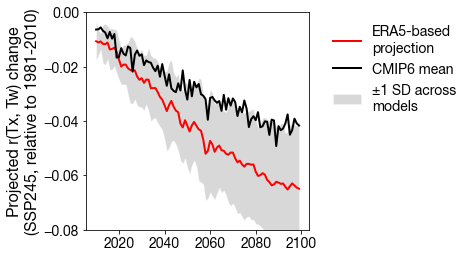

In [467]:
plt.figure(figsize=(4,4))
plt.ylim([-.08, 0])
cmip6_proj_2100_chg = []
ts = np.full([len(cmip6_models), 90], np.nan)

for m in range(len(cmip6_models)):
    cmip6_rtxtw_chg_da_spatial_mean = xgrid_utils.calc_spatial_mean(cmip6_rtxtw_chg[m])    
    ts[m,:] = cmip6_rtxtw_chg_da_spatial_mean.values
    cmip6_proj_2100_chg.append(cmip6_rtxtw_chg_da_spatial_mean[-1])
    

plt.fill_between(np.arange(2010,2100), np.nanmean(ts, axis=0)-np.nanstd(ts, axis=0), 
                np.nanmean(ts, axis=0)+np.nanstd(ts, axis=0), color='gray', alpha=0.3, ec='white', label='±1 SD across\nmodels')
plt.plot(np.arange(2010,2100), np.nanmean(ts, axis=0), '-r', lw=2, label='ERA5-based\nprojection')
plt.plot(np.arange(2010,2100), \
         (cmip6_hist_corr_spatial_mean.tx_tw_corr - cmip6_hist_corr_spatial_mean.tx_tw_corr.sel(year=slice('1981', '2010')).mean(dim='year')).mean(dim='model').sel(year=slice('2010', '2099')).values, \
         '-k', lw=2, label='CMIP6 mean')
l = plt.legend(fontsize=14, framealpha=.75, bbox_to_anchor=(1.05, 1.0), loc='upper left')
l.get_frame().set_linewidth(0)
plt.ylabel('Projected r(Tx, Tw) change\n(SSP245, relative to 1981-2010)')

cmip6_proj_2100_chg = np.array(cmip6_proj_2100_chg)
# plt.savefig('r(tx,tw)-in-cmip6-vs-era5-based-proj.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [469]:
cmip6_2100_chg = (cmip6_hist_corr_spatial_mean.tx_tw_corr - cmip6_hist_corr_spatial_mean.tx_tw_corr.sel(year=slice('1981', '2010')).mean(dim='year')).sel(year=slice('2010', '2099')).values[:,-1]

No handles with labels found to put in legend.


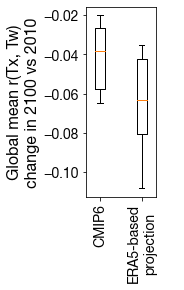

In [470]:
plt.figure(figsize=(1.25,3.5))
# plt.ylim([-., 0])
plt.xlim([.5, 1.5])
plt.boxplot([cmip6_2100_chg, cmip6_proj_2100_chg], positions=[.7, 1.3])
plt.xticks([.7,1.3], rotation=90)
plt.gca().set_xticklabels(['CMIP6', 'ERA5-based\nprojection'])
plt.ylabel('Global mean r(Tx, Tw)\nchange in 2100 vs 2010')
l = plt.legend(fontsize=14, framealpha=.75, bbox_to_anchor=(1.05, 1.0), loc='upper left')
l.get_frame().set_linewidth(0)
# plt.savefig('r(tx,tw)-vs-gmt-cmip6-lens-era5-hist.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [471]:
tx_on_tww_ds = []
tx_on_txx_ds = []
tw_on_tww_ds = []
tw_on_txx_ds = []

lh_on_tx_ds = []
pr_on_tx_ds = []

# Loop through each model
for model in cmip6_models:
    # Construct the filename
    filename = f'output/cmip6/tx_on_tww_1981_2100_ssp245_{model}.nc'
    # Open the dataset and append to the list
    ds = xr.open_dataset(filename)
    tx_on_tww_ds.append(ds)
    
    filename = f'output/cmip6/tx_on_txx_1981_2100_ssp245_{model}.nc'
    ds = xr.open_dataset(filename)
    tx_on_txx_ds.append(ds)

    filename = f'output/cmip6/tw_on_tww_1981_2100_ssp245_{model}.nc'
    ds = xr.open_dataset(filename)
    tw_on_tww_ds.append(ds)
    
    filename = f'output/cmip6/tw_on_txx_1981_2100_ssp245_{model}.nc'
    print(model)
    ds = xr.open_dataset(filename)
    tw_on_txx_ds.append(ds)
    
    time_dim = pd.date_range("1981-01-01", "2100-12-31", freq="AS")
    filename = f'output/cmip6/lh_on_tx_1981_2100_ssp245_{model}.nc'
    if os.path.isfile(filename):
        ds = xr.open_dataset(filename)
        ds['time'] = time_dim
        lh_on_tx_ds.append(ds)
        
    time_dim = pd.date_range("1981-01-01", "2100-12-31", freq="AS")
    filename = f'output/cmip6/pr_on_tx_1981_2100_ssp245_{model}.nc'
    if os.path.isfile(filename):
        ds = xr.open_dataset(filename)
        ds['time'] = time_dim
        pr_on_tx_ds.append(ds)


    
# # Concatenate all datasets along the 'model' dimension
tx_on_tww_ds = xr.concat(tx_on_tww_ds, dim='model')
tx_on_tww_ds['model'] = cmip6_models  
tx_on_tww_ds['time'] = np.arange(1981,2100+1)
tx_on_tww_ds = tx_on_tww_ds.rename({'__xarray_dataarray_variable__':'tx_on_tww'})
tx_on_tww_ds = tx_on_tww_ds.rename({'lat':'latitude', 'lon':'longitude'})
tx_on_tww_ds = tx_on_tww_ds.reindex(latitude=tx_on_tww_ds.latitude[::-1])

tx_on_txx_ds = xr.concat(tx_on_txx_ds, dim='model')
tx_on_txx_ds['model'] = cmip6_models
tx_on_txx_ds['time'] = np.arange(1981,2100+1)
tx_on_txx_ds = tx_on_txx_ds.rename({'__xarray_dataarray_variable__':'tx_on_txx'})
tx_on_txx_ds = tx_on_txx_ds.rename({'lat':'latitude', 'lon':'longitude'})
tx_on_txx_ds = tx_on_txx_ds.reindex(latitude=tx_on_txx_ds.latitude[::-1])

tw_on_tww_ds = xr.concat(tw_on_tww_ds, dim='model')
tw_on_tww_ds['model'] = cmip6_models  
tw_on_tww_ds['time'] = np.arange(1981,2100+1)
tw_on_tww_ds = tw_on_tww_ds.rename({'__xarray_dataarray_variable__':'tw_on_tww'})
tw_on_tww_ds = tw_on_tww_ds.rename({'lat':'latitude', 'lon':'longitude'})
tw_on_tww_ds = tw_on_tww_ds.reindex(latitude=tw_on_tww_ds.latitude[::-1])

tw_on_txx_ds = xr.concat(tw_on_txx_ds, dim='model')
tw_on_txx_ds['model'] = cmip6_models  
tw_on_txx_ds['time'] = np.arange(1981,2100+1)
tw_on_txx_ds = tw_on_txx_ds.rename({'__xarray_dataarray_variable__':'tw_on_txx'})
tw_on_txx_ds = tw_on_txx_ds.rename({'lat':'latitude', 'lon':'longitude'})
tw_on_txx_ds = tw_on_txx_ds.reindex(latitude=tw_on_txx_ds.latitude[::-1])


lh_on_tx_ds = xr.concat(lh_on_tx_ds, dim='model')
lh_on_tx_ds['model'] = cmip6_models  
# lh_on_tx_ds['time'] = time_dim#np.arange(1981,2100+1)
lh_on_tx_ds = lh_on_tx_ds.rename({'lat':'latitude', 'lon':'longitude'})
lh_on_tx_ds = lh_on_tx_ds.reindex(latitude=lh_on_tx_ds.latitude[::-1])

pr_on_tx_ds = xr.concat(pr_on_tx_ds, dim='model', coords='minimal')
pr_on_tx_ds['model'] = cmip6_models_pr
# lh_on_tx_ds['time'] = time_dim#np.arange(1981,2100+1)
pr_on_tx_ds = pr_on_tx_ds.rename({'lat':'latitude', 'lon':'longitude'})
pr_on_tx_ds = pr_on_tx_ds.reindex(latitude=pr_on_tx_ds.latitude[::-1])

access-cm2
bcc-csm2-mr
canesm5
cmcc-esm2
fgoals-g3
inm-cm4-8
inm-cm5-0
kace-1-0-g
mpi-esm1-2-hr
mpi-esm1-2-lr
mri-esm2-0
noresm2-lm
taiesm1


In [472]:
recalc = False

from scipy import signal
from statsmodels.tsa.tsatools import detrend

if not recalc:
    with open('cmip6_tw_txx_minus_tw_tww_per_r_tx_tw.dat', 'rb') as f:
        cmip6_tw_txx_minus_tw_tww_per_r_tx_tw = pickle.load(f)
    with open('cmip6_tx_tww_minus_tx_txx_per_r_tx_tw.dat', 'rb') as f:
        cmip6_tx_tww_minus_tx_txx_per_r_tx_tw = pickle.load(f)
    with open('cmip6_r_tx_tw_slope.dat', 'rb') as f:
        cmip6_r_tx_tw_slope = pickle.load(f)
    with open('cmip6_lh_on_tx_slope.dat', 'rb') as f:
        cmip6_lh_on_tx_slope = pickle.load(f)

else:
    
    cmip6_tw_txx_minus_tw_tww_per_r_tx_tw = np.full([len(cmip6_models), cmip6_hist_corr_spatial.latitude.size, cmip6_hist_corr_spatial.longitude.size], np.nan)
    cmip6_tx_tww_minus_tx_txx_per_r_tx_tw = np.full([len(cmip6_models),cmip6_hist_corr_spatial.latitude.size, cmip6_hist_corr_spatial.longitude.size], np.nan)
    cmip6_r_tx_tw_slope = np.full([len(cmip6_models),cmip6_hist_corr_spatial.latitude.size, cmip6_hist_corr_spatial.longitude.size], np.nan)
    cmip6_lh_on_tx_slope = np.full([len(cmip6_models),cmip6_hist_corr_spatial.latitude.size, cmip6_hist_corr_spatial.longitude.size], np.nan)
    cmip6_pr_on_tx_slope = np.full([len(cmip6_models),cmip6_hist_corr_spatial.latitude.size, cmip6_hist_corr_spatial.longitude.size], np.nan)


    for m in range(len(cmip6_models)):
        print(f'processing {cmip6_models[m]}')
        for xlat in range(cmip6_hist_corr_spatial.latitude.size):
            for ylon in range(cmip6_hist_corr_spatial.longitude.size):

                if ~np.isnan(cmip6_hist_corr_spatial.tx_tw_corr[m, 1, xlat, ylon]):

                    cur_r_tx_tw = cmip6_hist_corr_spatial.tx_tw_corr.sel(year=slice('1981','2021')).values[m, :, xlat, ylon]

                    cur_tw_on_txx = (tw_on_txx_ds.tw_on_txx.sel(time=slice('1981','2021')).values[m, :, xlat, ylon] - \
                            tw_on_tww_ds.tw_on_tww.sel(time=slice('1981','2021')).values[m, :, xlat, ylon])

                    cur_tx_on_tww = (tx_on_tww_ds.tx_on_tww.sel(time=slice('1981','2021')).values[m, :, xlat, ylon] - \
                             tx_on_txx_ds.tx_on_txx.sel(time=slice('1981','2021')).values[m, :, xlat, ylon])

                    cur_lh_on_tx = lh_on_tx_ds.hfls.sel(time=slice('1981','2021')).values[m, :, xlat, ylon]

                    if cmip6_models[m] in cmip6_models_pr:
                        cur_pr_on_tx = pr_on_tx_ds.pr.sel(time=slice('1981','2021')).sel(model=cmip6_models[m]).values[:, xlat, ylon]

                    nn_ts = np.where((~np.isnan(cur_r_tx_tw)) & (~np.isnan(cur_tw_on_txx)) & (~np.isnan(cur_tx_on_tww)))[0]

                    if nn_ts.size > 20:
                        cur_r_tx_tw_detrend = detrend(cur_r_tx_tw[nn_ts], order=1)
                        cur_tw_on_txx_detrend = detrend(cur_tw_on_txx[nn_ts], order=1)
                        cur_tx_on_tww_detrend = detrend(cur_tx_on_tww[nn_ts], order=1)

                        X = sm.add_constant(cur_r_tx_tw_detrend)
                        mdl = sm.OLS(cur_tw_on_txx_detrend, X).fit()
                        cmip6_tw_txx_minus_tw_tww_per_r_tx_tw[m, xlat, ylon] = mdl.params[1]

                        X = sm.add_constant(cur_r_tx_tw_detrend)
                        mdl = sm.OLS(cur_tx_on_tww_detrend, X).fit()
                        cmip6_tx_tww_minus_tx_txx_per_r_tx_tw[m, xlat, ylon] = mdl.params[1]

                        X = sm.add_constant(range(nn_ts.size))
                        mdl = sm.OLS(cur_r_tx_tw[nn_ts], X).fit()
                        cmip6_r_tx_tw_slope[m, xlat, ylon] = mdl.params[1]

                    nn = np.where((~np.isnan(cur_lh_on_tx)))[0]
                    if nn.size > 20:
                        X = sm.add_constant(range(nn.size))
                        mdl = sm.OLS(cur_lh_on_tx[nn], X).fit()
                        cmip6_lh_on_tx_slope[m, xlat, ylon] = mdl.params[1]

                    if cmip6_models[m] in cmip6_models_pr:
                        nn = np.where((~np.isnan(cur_pr_on_tx)))[0]
                        if nn.size > 20:
                            X = sm.add_constant(range(nn.size))
                            mdl = sm.OLS(cur_pr_on_tx[nn], X).fit()
                            cmip6_pr_on_tx_slope[m, xlat, ylon] = mdl.params[1]

    with open('cmip6_tw_txx_minus_tw_tww_per_r_tx_tw.dat', 'wb') as f:
        pickle.dump(cmip6_tw_txx_minus_tw_tww_per_r_tx_tw, f)
    with open('cmip6_tx_tww_minus_tx_txx_per_r_tx_tw.dat', 'wb') as f:
        pickle.dump(cmip6_tx_tww_minus_tx_txx_per_r_tx_tw, f)
    with open('cmip6_r_tx_tw_slope.dat', 'wb') as f:
        pickle.dump(cmip6_r_tx_tw_slope, f)
    with open('cmip6_lh_on_tx_slope.dat', 'wb') as f:
        pickle.dump(cmip6_lh_on_tx_slope, f)
    with open('cmip6_pr_on_tx_slope.dat', 'wb') as f:
        pickle.dump(cmip6_pr_on_tx_slope, f)

In [473]:
with open('era5_r_tx_tw_vs_tw_on_tx_slope.dat', 'rb') as f:
    era5_tw_txx_minus_tw_tww_per_r_tx_tw = pickle.load(f)
    
    regridder = xe.Regridder({'lat':land_sea_mask_60.latitude, 'lon':land_sea_mask_60.longitude, 'era5_tw_txx_minus_tw_tww_per_r_tx_tw':era5_tw_txx_minus_tw_tww_per_r_tx_tw}, regridMesh_global.sel(lat=slice(-60,60)), 'bilinear', reuse_weights=False)
    era5_tw_txx_minus_tw_tww_per_r_tx_tw_regrid = regridder(era5_tw_txx_minus_tw_tww_per_r_tx_tw);

with open('era5_r_tx_tw_vs_tx_on_tw_slope.dat', 'rb') as f:
    era5_tx_tww_minus_tx_txx_per_r_tx_tw = pickle.load(f)
    
    regridder = xe.Regridder({'lat':land_sea_mask_60.latitude, 'lon':land_sea_mask_60.longitude, 'era5_tx_tww_minus_tx_txx_per_r_tx_tw':era5_tx_tww_minus_tx_txx_per_r_tx_tw}, regridMesh_global.sel(lat=slice(-60,60)), 'bilinear', reuse_weights=False)
    era5_tx_tww_minus_tx_txx_per_r_tx_tw_regrid = regridder(era5_tx_tww_minus_tx_txx_per_r_tx_tw);
    
with open('era5_r_tx_tw_slope.dat', 'rb') as f:
    era5_r_tx_tw_slope = pickle.load(f)

    regridder = xe.Regridder({'lat':land_sea_mask_60.latitude, 'lon':land_sea_mask_60.longitude, 'r_tx_tw_slope':era5_r_tx_tw_slope}, regridMesh_global.sel(lat=slice(-60,60)), 'bilinear', reuse_weights=False)
    era5_r_tx_tw_slope_regrid = regridder(era5_r_tx_tw_slope);
    

Overwrite existing file: bilinear_481x1440_81x240.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: bilinear_481x1440_81x240.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: bilinear_481x1440_81x240.nc 
 You can set reuse_weights=True to save computing time.


In [534]:

cmip6_r_tx_tw_slope_da = xr.DataArray(
    cmip6_r_tx_tw_slope,  # Data
    dims=['model', 'latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': cmip6_lat_sel.lat.values,  # Coordinate for latitude
        'longitude': cmip6_lon_sel.lon.values  # Coordinate for longitude
    }
)

cmip6_r_tx_tw_slope_da = cmip6_r_tx_tw_slope_da.reindex(latitude=cmip6_r_tx_tw_slope_da.latitude[::-1])

cmip6_r_tx_tw_slope_da_means = xgrid_utils.calc_spatial_mean(cmip6_r_tx_tw_slope_da)


cmip6_tw_txx_minus_tw_tww_per_r_tx_tw_da = xr.DataArray(
    cmip6_tw_txx_minus_tw_tww_per_r_tx_tw,  # Data
    dims=['model', 'latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': cmip6_lat_sel.lat.values,  # Coordinate for latitude
        'longitude': cmip6_lon_sel.lon.values  # Coordinate for longitude
    }
)

cmip6_tw_txx_minus_tw_tww_per_r_tx_tw_da = cmip6_tw_txx_minus_tw_tww_per_r_tx_tw_da.reindex(latitude=cmip6_tw_txx_minus_tw_tww_per_r_tx_tw_da.latitude[::-1])

cmip6_tw_txx_minus_tw_tww_per_r_tx_tw_da_means = xgrid_utils.calc_spatial_mean(cmip6_tw_txx_minus_tw_tww_per_r_tx_tw_da)


cmip6_tx_tww_minus_tx_txx_per_r_tx_tw_da = xr.DataArray(
    cmip6_tx_tww_minus_tx_txx_per_r_tx_tw,  # Data
    dims=['model', 'latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': cmip6_lat_sel.lat.values,  # Coordinate for latitude
        'longitude': cmip6_lon_sel.lon.values  # Coordinate for longitude
    }
)
cmip6_tx_tww_minus_tx_txx_per_r_tx_tw_da = cmip6_tx_tww_minus_tx_txx_per_r_tx_tw_da.reindex(latitude=cmip6_tx_tww_minus_tx_txx_per_r_tx_tw_da.latitude[::-1])

cmip6_tx_tww_minus_tx_txx_per_r_tx_tw_da_means = xgrid_utils.calc_spatial_mean(cmip6_tx_tww_minus_tx_txx_per_r_tx_tw_da)



era5_r_tx_tw_slope_da = xr.DataArray(
    era5_r_tx_tw_slope,  # Data
    dims=['latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': land_sea_mask_60.latitude.values,  # Coordinate for latitude
        'longitude': land_sea_mask_60.longitude.values  # Coordinate for longitude
    }
)

regridder = xe.Regridder({'lat':era5_r_tx_tw_slope_da.latitude.values, 'lon':era5_r_tx_tw_slope_da.longitude.values, 'data':era5_r_tx_tw_slope_da}, 
                         {'lat': regridMesh_global.sel(lat=slice(-60,60)).lat.values, 'lon': regridMesh_global.sel(lat=slice(-60,60)).lon.values}, 'bilinear', reuse_weights=False)
era5_r_tx_tw_slope_da_regrid = regridder(era5_r_tx_tw_slope_da)
era5_r_tx_tw_slope_da_regrid = era5_r_tx_tw_slope_da_regrid.reindex(lat=era5_r_tx_tw_slope_da_regrid.lat[::-1])

era5_r_tx_tw_slope_means = xgrid_utils.calc_spatial_mean(era5_r_tx_tw_slope_da)

era5_tx_tww_minus_tx_txx_per_r_tx_tw_da = xr.DataArray(
    era5_tx_tww_minus_tx_txx_per_r_tx_tw,  # Data
    dims=['latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': land_sea_mask_60.latitude.values,  # Coordinate for latitude
        'longitude': land_sea_mask_60.longitude.values  # Coordinate for longitude
    }
)

regridder = xe.Regridder({'lat':era5_tx_tww_minus_tx_txx_per_r_tx_tw_da.latitude.values, 'lon':era5_tx_tww_minus_tx_txx_per_r_tx_tw_da.longitude.values, 'data':era5_tx_tww_minus_tx_txx_per_r_tx_tw_da}, 
                         {'lat': regridMesh_global.sel(lat=slice(-60,60)).lat.values, 'lon': regridMesh_global.sel(lat=slice(-60,60)).lon.values}, 'bilinear', reuse_weights=False)
era5_tx_tww_minus_tx_txx_per_r_tx_tw_da_regrid = regridder(era5_tx_tww_minus_tx_txx_per_r_tx_tw_da)
era5_tx_tww_minus_tx_txx_per_r_tx_tw_da_regrid = era5_tx_tww_minus_tx_txx_per_r_tx_tw_da_regrid.reindex(lat=era5_tx_tww_minus_tx_txx_per_r_tx_tw_da_regrid.lat[::-1])


era5_tx_tww_minus_tx_txx_per_r_tx_tw_da_means = xgrid_utils.calc_spatial_mean(era5_tx_tww_minus_tx_txx_per_r_tx_tw_da)

era5_tw_txx_minus_tw_tww_per_r_tx_tw_da = xr.DataArray(
    era5_tw_txx_minus_tw_tww_per_r_tx_tw,  # Data
    dims=['latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': land_sea_mask_60.latitude.values,  # Coordinate for latitude
        'longitude': land_sea_mask_60.longitude.values  # Coordinate for longitude
    }
)
regridder = xe.Regridder({'lat':era5_tw_txx_minus_tw_tww_per_r_tx_tw_da.latitude.values, 'lon':era5_tw_txx_minus_tw_tww_per_r_tx_tw_da.longitude.values, 'data':era5_tw_txx_minus_tw_tww_per_r_tx_tw_da}, 
                         {'lat': regridMesh_global.sel(lat=slice(-60,60)).lat.values, 'lon': regridMesh_global.sel(lat=slice(-60,60)).lon.values}, 'bilinear', reuse_weights=False)
era5_tw_txx_minus_tw_tww_per_r_tx_tw_da_regrid = regridder(era5_tw_txx_minus_tw_tww_per_r_tx_tw_da)
era5_tw_txx_minus_tw_tww_per_r_tx_tw_da_regrid = era5_tw_txx_minus_tw_tww_per_r_tx_tw_da_regrid.reindex(lat=era5_tw_txx_minus_tw_tww_per_r_tx_tw_da_regrid.lat[::-1])

era5_tw_txx_minus_tw_tww_per_r_tx_tw_da_means = xgrid_utils.calc_spatial_mean(era5_tw_txx_minus_tw_tww_per_r_tx_tw_da)

Overwrite existing file: bilinear_481x1440_81x240.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: bilinear_481x1440_81x240.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: bilinear_481x1440_81x240.nc 
 You can set reuse_weights=True to save computing time.


In [537]:
# m=0

# cmip6_r_tx_tw_slope_1d = cmip6_r_tx_tw_slope[m,:,:].reshape([cmip6_r_tx_tw_slope[0,:,:].size])
# cmip6_lh_on_tx_slope_1d = cmip6_lh_on_tx_slope[m,:,:].reshape([cmip6_lh_on_tx_slope[0,:,:].size])
# cmip6_pr_on_tx_slope_1d = cmip6_pr_on_tx_slope[m,:,:].reshape([cmip6_lh_on_tx_slope[0,:,:].size])*3600*1000

cmip6_r_tx_tw_slope_1d = np.nanmean(cmip6_r_tx_tw_slope,axis=0).reshape([cmip6_r_tx_tw_slope[0,:,:].size])
cmip6_lh_on_tx_slope_1d = np.nanmean(cmip6_lh_on_tx_slope,axis=0).reshape([cmip6_lh_on_tx_slope[0,:,:].size])
cmip6_pr_on_tx_slope_1d = np.nanmean(cmip6_pr_on_tx_slope,axis=0).reshape([cmip6_lh_on_tx_slope[0,:,:].size])*3600*1000

In [538]:

tx_tw_corr_trend_percentile_levels = np.nanpercentile(cmip6_r_tx_tw_slope_1d, np.arange(1,99))
abs_diff = np.abs(cmip6_r_tx_tw_slope_1d[:, np.newaxis] - tx_tw_corr_trend_percentile_levels)
nn = np.where(~np.isnan(abs_diff[:,0]))[0]

# Find the index of the minimum difference for each data point
min_diff_indices = np.argmin(abs_diff, axis=1)

# Map the indices of the minimum difference to the corresponding percentile
tx_tw_corr_trend_percentiles_1d = min_diff_indices.astype(float)
tx_tw_corr_trend_percentiles_1d[tx_tw_corr_trend_percentiles_1d == 0] = np.nan


lh_on_tx_trend_percentile_levels = np.nanpercentile(cmip6_lh_on_tx_slope_1d, np.arange(1,99))
abs_diff = np.abs(cmip6_lh_on_tx_slope_1d[:, np.newaxis] - lh_on_tx_trend_percentile_levels)
nn = np.where(~np.isnan(abs_diff[:,0]))[0]

# Find the index of the minimum difference for each data point
min_diff_indices = np.argmin(abs_diff, axis=1)

# Map the indices of the minimum difference to the corresponding percentile
lh_on_tx_trend_percentiles_1d = min_diff_indices.astype(float)
lh_on_tx_trend_percentiles_1d[lh_on_tx_trend_percentiles_1d == 0] = np.nan



pr_on_tx_trend_percentile_levels = np.nanpercentile(cmip6_pr_on_tx_slope_1d, np.arange(1,99))
abs_diff = np.abs(cmip6_pr_on_tx_slope_1d[:, np.newaxis] - pr_on_tx_trend_percentile_levels)
nn = np.where(~np.isnan(abs_diff[:,0]))[0]

# Find the index of the minimum difference for each data point
min_diff_indices = np.argmin(abs_diff, axis=1)

# Map the indices of the minimum difference to the corresponding percentile
pr_on_tx_trend_percentiles_1d = min_diff_indices.astype(float)
pr_on_tx_trend_percentiles_1d[pr_on_tx_trend_percentiles_1d == 0] = np.nan



In [539]:
nn = np.where(~np.isnan(tx_tw_corr_trend_percentiles_1d) & ~np.isnan(pr_on_tx_trend_percentiles_1d))[0]

X = sm.add_constant(tx_tw_corr_trend_percentiles_1d[nn])
mdl = sm.OLS(pr_on_tx_trend_percentiles_1d[nn], X).fit()

mdl.summary()
# plt.scatter(tx_tw_corr_trend_percentiles_1d, lh_on_tx_trend_percentiles_1d)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     142.6
Date:                Thu, 04 Apr 2024   Prob (F-statistic):           1.86e-32
Time:                        16:15:35   Log-Likelihood:                -24799.
No. Observations:                5219   AIC:                         4.960e+04
Df Residuals:                    5217   BIC:                         4.961e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         41.6756      0.785     53.087      0.000      40.137      43.215
x1             0.1637      0.014     11.943      0.000       0.137       0.191
==============================================================================
Omnibus:                     3062.553   Durbin-Watson:                   0.462
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              290.622
Skew:                          -0.034   Prob(JB):                     7.80e-64
Kurtosis:                       1.846   Cond. No.                         116.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [540]:
tx_tw_corr_trend_deciles_inds = {}
for i in range(10, 101, 10):
    tx_tw_corr_trend_deciles_inds[i] = np.where((tx_tw_corr_trend_percentiles_1d < i) & (tx_tw_corr_trend_percentiles_1d >= i-10))[0]

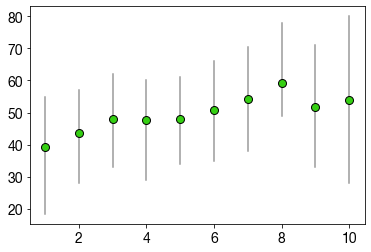

In [541]:
x=1
for i in tx_tw_corr_trend_deciles_inds.keys():
    cur_x = x
    y1 = np.nanpercentile(pr_on_tx_trend_percentiles_1d[tx_tw_corr_trend_deciles_inds[i]], 33)
    y2 = np.nanpercentile(pr_on_tx_trend_percentiles_1d[tx_tw_corr_trend_deciles_inds[i]], 67)
    plt.plot([cur_x,cur_x], [y1, y2], '-', c='#999999')
    if i == 10:
        plt.plot([cur_x], [np.nanmean(pr_on_tx_trend_percentiles_1d[tx_tw_corr_trend_deciles_inds[i]])], 'o', ms=8, mec='k', mfc='#35cf13', mew=1, label='LH')
    else:
        plt.plot([cur_x], [np.nanmean(pr_on_tx_trend_percentiles_1d[tx_tw_corr_trend_deciles_inds[i]])], 'o', ms=8, mec='k', mfc='#35cf13', mew=1)
    x+=1

In [666]:

cmip6_tw_on_txx_era5_proj_ts = np.full([len(cmip6_models), np.arange(2010,2100).size, cmip6_hist_corr_spatial.latitude.size, cmip6_hist_corr_spatial.longitude.size], np.nan)
cmip6_tx_on_tww_era5_proj_ts = np.full([len(cmip6_models), np.arange(2010,2100).size, cmip6_hist_corr_spatial.latitude.size, cmip6_hist_corr_spatial.longitude.size], np.nan)

for m in range(len(cmip6_models)):
    print(cmip6_models[m])
    
    # full tw_on_tx change
    cur_model_full_tw_on_tx_chg = (((tw_on_txx_ds.tw_on_txx[m,:,:,:]-tw_on_tww_ds.tw_on_tww[m,:,:,:]).sel(time=slice('2010', '2100')) - \
                                    (tw_on_txx_ds.tw_on_txx[m,:,:,:]-tw_on_tww_ds.tw_on_tww[m,:,:,:]).sel(time=slice('1981', '2010')).mean(dim='time')).values)
    
    # slope r(tx,tw) vs tw_on_tx
    cur_model_tw_on_tx_per_r_tx_tw = cmip6_tw_txx_minus_tw_tww_per_r_tx_tw_da[m,:,:].values
    
    # r(tx,tw) change
    cur_model_r_tx_tw_chg = (cmip6_hist_corr_spatial.tx_tw_corr[m,:,:,:].sel(year=slice('2010', '2100')) - cmip6_hist_corr_spatial.tx_tw_corr[m,:,:,:].sel(year=slice('1981', '2010')).mean(dim='year')).values
    
    cur_cmip6_era5_adjusted_r_tx_tw_chg = cmip6_rtxtw_gmt_chg[m].values
    
    for xlat in range(cmip6_hist_corr_spatial.latitude.size):
        for ylon in range(cmip6_hist_corr_spatial.longitude.size):
            
            cur_cmip6_full_tw_on_tx_chg_gridcell = cur_model_full_tw_on_tx_chg[:, xlat, ylon]
            cur_model_tw_on_tx_per_r_tx_tw_gridcell = cur_model_tw_on_tx_per_r_tx_tw[xlat, ylon]
            cur_cmip6_r_tx_tw_chg_gridcell = cur_model_r_tx_tw_chg[:, xlat, ylon]
            cur_cmip6_era5_adjusted_r_tx_tw_chg_gridcell = cur_cmip6_era5_adjusted_r_tx_tw_chg[:, xlat, ylon]
            
            nn = np.where(~np.isnan(cur_cmip6_r_tx_tw_chg_gridcell))[0]
            
            for y in range(np.arange(2010,2100).size):
                if nn.size > 10:
                    cmip6_tw_on_txx_era5_proj_ts[m, y, xlat, ylon] = cur_cmip6_full_tw_on_tx_chg_gridcell[y] - \
                                                                        cur_cmip6_r_tx_tw_chg_gridcell[y] * cur_model_tw_on_tx_per_r_tx_tw_gridcell + \
                                                                        cur_cmip6_era5_adjusted_r_tx_tw_chg_gridcell[y] * era5_tw_txx_minus_tw_tww_per_r_tx_tw_da_regrid.values[xlat, ylon]


#                     cmip6_tw_on_txx_era5_proj_ts[m, y, xlat, ylon] = cur_cmip6_r_tx_tw_chg_gridcell[y] * era5_r_tx_tw_vs_tw_on_tx_slope_mean[xlat, ylon]
#                     cmip6_tx_on_tww_era5_proj_ts[m, y, xlat, ylon] = cur_cmip6_r_tx_tw_chg_gridcell[y] * era5_r_tx_tw_vs_tx_on_tw_slope_mean[xlat, ylon]


access-cm2
bcc-csm2-mr
canesm5
cmcc-esm2
fgoals-g3
inm-cm4-8
inm-cm5-0
kace-1-0-g
mpi-esm1-2-hr
mpi-esm1-2-lr
mri-esm2-0
noresm2-lm
taiesm1


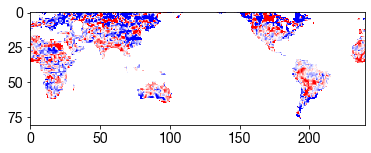

In [646]:
plt.imshow(cur_model_tw_on_tx_per_r_tx_tw-era5_tw_txx_minus_tw_tww_per_r_tx_tw_da_regrid.values, vmin=-5, vmax=5, cmap='bwr')

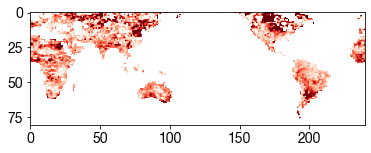

In [642]:
plt.imshow(cur_model_tw_on_tx_per_r_tx_tw, vmin=0, vmax=10, cmap='Reds')

In [680]:
cmip6_tw_on_txx_era5_proj_ts_da = xr.DataArray(
    data=cmip6_tw_on_txx_era5_proj_ts,  # Use your data array here
    dims=["model", "time", "latitude", "longitude"],  # Specify the dimensions names
    coords={
        "model":cmip6_models,
        "time":np.arange(2010,2100),
        "latitude": cmip6_hist_corr_spatial.latitude.values,  # Latitude coordinates
        "longitude": cmip6_hist_corr_spatial.longitude.values  # Longitude coordinates
    }
)

cmip6_tx_on_tww_era5_proj_ts_da = xr.DataArray(
    data=cmip6_tx_on_tww_era5_proj_ts,  # Use your data array here
    dims=["model", "time", "latitude", "longitude"],  # Specify the dimensions names
    coords={
        "model":cmip6_models,
        "time":np.arange(2010,2100),
        "latitude": cmip6_hist_corr_spatial.latitude.values,  # Latitude coordinates
        "longitude": cmip6_hist_corr_spatial.longitude.values  # Longitude coordinates
    }
)

cmip6_tw_on_txx_era5_proj_ts_spatial_mean = xgrid_utils.calc_spatial_mean(cmip6_tw_on_txx_era5_proj_ts_da)
cmip6_tx_on_tww_era5_proj_ts_spatial_mean = xgrid_utils.calc_spatial_mean(cmip6_tx_on_tww_era5_proj_ts_da)


In [668]:
m=0

In [681]:
x = cmip6_tw_on_txx_era5_proj_ts_da.mean(dim='model').sel(time=slice('2070', '2100')).mean(dim='time')

In [682]:
y = (((tw_on_txx_ds.tw_on_txx-tw_on_tww_ds.tw_on_tww).mean(dim='model').sel(time=slice('2070', '2100')).mean(dim='time')) - \
 ((tw_on_txx_ds.tw_on_txx-tw_on_tww_ds.tw_on_tww).mean(dim='model').sel(time=slice('1981', '2010')).mean(dim='time')))

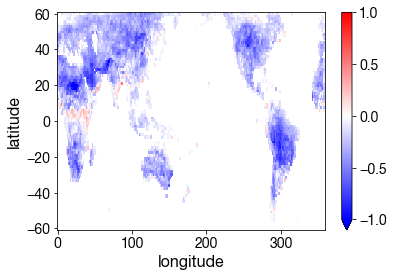

In [683]:
y.plot(vmin=-1, vmax=1, cmap='bwr')

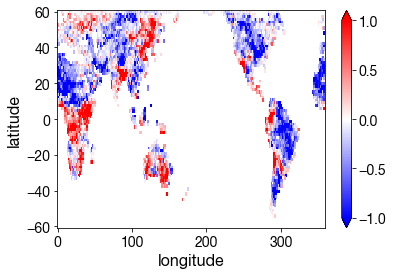

In [684]:
x.plot(vmin=-1, vmax=1, cmap='bwr')

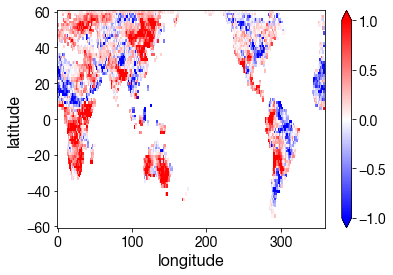

In [685]:
(x-y).plot(vmin=-1, vmax=1, cmap='bwr')

ValueError: x and y must have same first dimension, but have shapes (90,) and (1,)

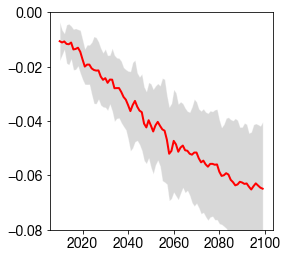

In [167]:
plt.figure(figsize=(4,4))
plt.ylim([-.08, 0])
cmip6_proj_2100_chg = []
ts = np.full([len(cmip6_models), 90], np.nan)

for m in range(len(cmip6_models)):
    cmip6_rtxtw_chg_da_spatial_mean = xgrid_utils.calc_spatial_mean(cmip6_rtxtw_chg[m])    
    ts[m,:] = cmip6_rtxtw_chg_da_spatial_mean.values
    cmip6_proj_2100_chg.append(cmip6_rtxtw_chg_da_spatial_mean[-1])
    

plt.fill_between(np.arange(2010,2100), np.nanmean(ts, axis=0)-np.nanstd(ts, axis=0), 
                np.nanmean(ts, axis=0)+np.nanstd(ts, axis=0), color='gray', alpha=0.3, ec='white', label='±1 SD across\nmodels')
plt.plot(np.arange(2010,2100), np.nanmean(ts, axis=0), '-r', lw=2, label='ERA5-based\nprojection')
plt.plot(np.arange(2010,2100), \
         (cmip6_hist_corr_spatial_mean - cmip6_hist_corr_spatial_mean.sel(year=slice('1981', '2010')).mean(dim='year')).mean(dim='model').sel(year=slice('2010', '2099')).values, \
         '-k', lw=2, label='CMIP6 mean')
l = plt.legend(fontsize=14, framealpha=.75, bbox_to_anchor=(1.05, 1.0), loc='upper left')
l.get_frame().set_linewidth(0)
plt.ylabel('Projected r(Tx, Tw) change\n(SSP245, relative to 1981-2010)')

cmip6_proj_2100_chg = np.array(cmip6_proj_2100_chg)

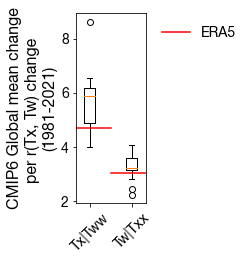

In [199]:
plt.figure(figsize=(1.25,3.5))
# plt.ylim([-.012, 0]?)
plt.xlim([.5, 1.5])
plt.boxplot([cmip6_tx_tww_minus_tx_txx_per_r_tx_tw_da_means, cmip6_tw_txx_minus_tw_tww_per_r_tx_tw_da_means], positions=[.7, 1.3])
plt.plot([.5, 1], [era5_tx_tww_minus_tx_txx_per_r_tx_tw_da_means, era5_tx_tww_minus_tx_txx_per_r_tx_tw_da_means], '-r', label='ERA5')
plt.plot([1, 1.5], [era5_tw_txx_minus_tw_tww_per_r_tx_tw_da_means, era5_tw_txx_minus_tw_tww_per_r_tx_tw_da_means], '-r')
plt.xticks([.7,1.3], rotation=45)
plt.gca().set_xticklabels(['Tx|Tww', 'Tw|Txx'])
plt.ylabel('CMIP6 Global mean change\nper r(Tx, Tw) change \n(1981-2021)')
l = plt.legend(fontsize=14, framealpha=.75, bbox_to_anchor=(1.05, 1.0), loc='upper left')
l.get_frame().set_linewidth(0)
# plt.savefig('r(tx,tw)-vs-gmt-cmip6-lens-era5-hist.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

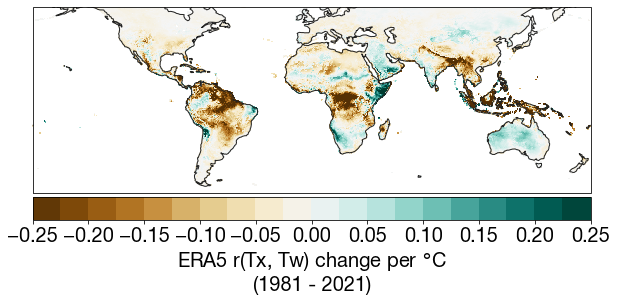

In [213]:
plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -.25
v2 = .251
vstep = .025
vlabelstep = .05

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = era5_r_tx_tw_per_deg

c = plt.pcolormesh(land_sea_mask_60.longitude, land_sea_mask_60.latitude, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('ERA5 r(Tx, Tw) change per $\degree$C\n(1981 - 2021)', fontsize=20)

# plt.savefig('t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


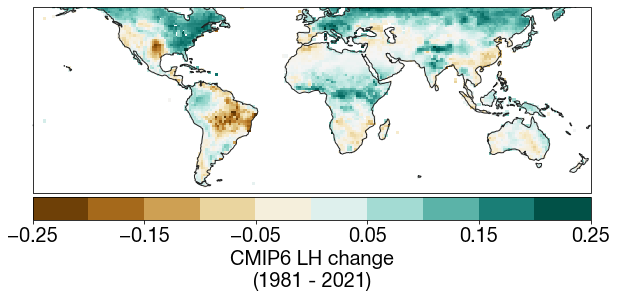

In [214]:
plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -.25
v2 = .251
vstep = .05
vlabelstep = .1

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = np.nanmean(cmip6_lh_on_tx_slope, axis=0)

c = plt.pcolormesh(cmip6_hist_corr_spatial.longitude, cmip6_hist_corr_spatial.latitude, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('CMIP6 LH change\n(1981 - 2021)', fontsize=20)

# plt.savefig('t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


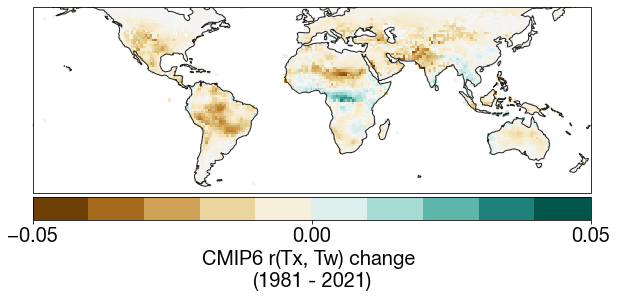

In [215]:
plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, -180, 60, -60])

v1 = -.05
v2 = .051
vstep = .01
vlabelstep = .05

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = np.nanmean(cmip6_r_tx_tw_slope, axis=0)*10

c = plt.pcolormesh(cmip6_hist_corr_spatial.longitude, cmip6_hist_corr_spatial.latitude, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('CMIP6 r(Tx, Tw) change \n(1981 - 2021)', fontsize=20)

# plt.savefig('t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


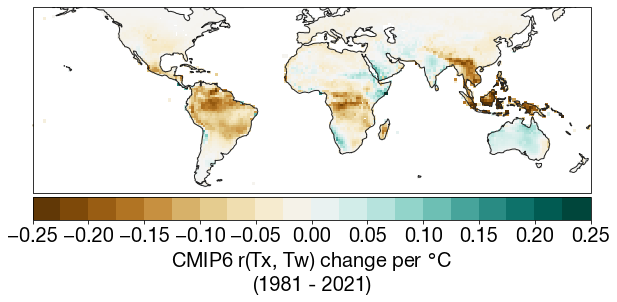

In [216]:
plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -.25
v2 = .251
vstep = .025
vlabelstep = .05

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = np.nanmean(cmip6_r_tx_tw_per_deg, axis=0)

c = plt.pcolormesh(cmip6_hist_corr_spatial.longitude, cmip6_hist_corr_spatial.latitude, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('CMIP6 r(Tx, Tw) change per $\degree$C\n(1981 - 2021)', fontsize=20)

# plt.savefig('t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


In [217]:
regridder = xe.Regridder({'lat':land_sea_mask_60.latitude.values, 'lon':land_sea_mask_60.longitude.values, 'data':era5_r_tx_tw_per_deg}, 
                         regridMesh_global.sel(lat=slice(-60,60)), 'bilinear', reuse_weights=False)
era5_r_tx_tw_per_deg_regrid_to_cmip6 = regridder(era5_r_tx_tw_per_deg);

Overwrite existing file: bilinear_481x1440_81x240.nc 
 You can set reuse_weights=True to save computing time.


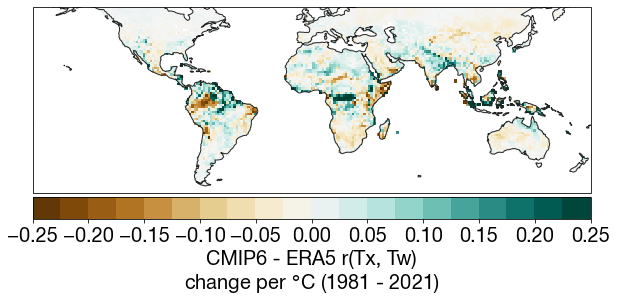

In [220]:
plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -.25
v2 = .251
vstep = .025
vlabelstep = .05

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = np.nanmean(cmip6_r_tx_tw_per_deg, axis=0)-era5_r_tx_tw_per_deg_regrid_to_cmip6

c = plt.pcolormesh(cmip6_hist_corr_spatial.longitude, cmip6_hist_corr_spatial.latitude, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('CMIP6 - ERA5 r(Tx, Tw)\nchange per $\degree$C (1981 - 2021)', fontsize=20)

# plt.savefig('t-et-chg-per-deg-C-cmip6-minus-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


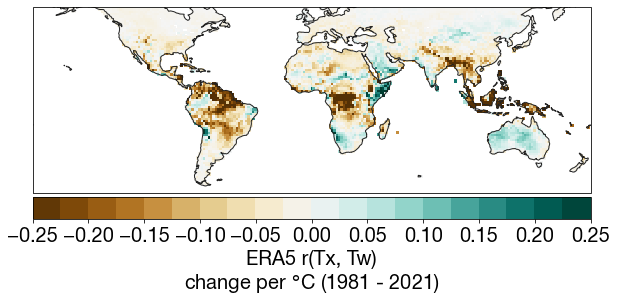

In [219]:
plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -.25
v2 = .251
vstep = .025
vlabelstep = .05

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = era5_r_tx_tw_per_deg_regrid_to_cmip6

c = plt.pcolormesh(cmip6_hist_corr_spatial.longitude, cmip6_hist_corr_spatial.latitude, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('ERA5 r(Tx, Tw)\nchange per $\degree$C (1981 - 2021)', fontsize=20)

# plt.savefig('t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


In [163]:
# Step 1: Determine the sign of the variable
signs = np.sign(cmip6_r_tx_tw_per_deg)

# Step 2: Count the agreement on the sign for each lat-lon point
# Positive agreement count
positive_agreement = np.sum(signs == 1, axis=0)
# Negative agreement count
negative_agreement = np.sum(signs == -1, axis=0)

# Total agreement considering both positive and negative
total_agreement = np.maximum(positive_agreement, negative_agreement).astype(numpy.float32)/len(cmip6_models)

total_agreement[np.isnan(cmip6_r_tx_tw_per_deg[0,:,:])] = np.nan

In [15]:
cmip6_tx_tw_minus_tx_tx_spatial_mean = xgrid_utils.calc_spatial_mean(tx_on_tww_ds.tx_on_tww - tx_on_txx_ds.tx_on_txx)
cmip6_tw_tx_minus_tw_tw_spatial_mean = xgrid_utils.calc_spatial_mean(tw_on_txx_ds.tw_on_txx - tw_on_tww_ds.tw_on_tww)


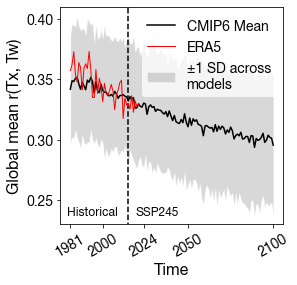

In [149]:
import matplotlib.pyplot as plt

# Calculate the mean and standard deviation across the 'latitude', 'longitude', and 'model' dimensions
mean_vals = xgrid_utils.calc_spatial_mean(cmip6_hist_corr_spatial.tx_tw_corr).mean(dim='model')
std_dev = xgrid_utils.calc_spatial_mean(cmip6_hist_corr_spatial.tx_tw_corr).std(dim='model')

# Calculate the upper and lower bounds as mean ± 1 standard deviation
upper_bound = mean_vals + std_dev
lower_bound = mean_vals - std_dev

# Assuming 'time' is the dimension along which you want to plot
time = mean_vals['year']  # Adjust this if your time dimension is named differently

plt.figure(figsize=(4, 4))
plt.ylim([.23, .41])
plt.plot(time, mean_vals, label='CMIP6 Mean', color='k')
plt.plot([2015, 2015], [.22, .42], '--k')
plt.fill_between(time, lower_bound, upper_bound, color='gray', alpha=0.3, ec='white', label='±1 SD across\nmodels')
plt.plot(np.arange(1981,2021+1), tx_tw_corr_ts.tx_tw_corr, c='r', lw=1, label='ERA5')

plt.text(1994, .24, "Historical", ha='center', va='center', fontsize=12)  # Adjust coordinates and fontsize as necessary
plt.text(2032, .24, "SSP245", ha='center', va='center', fontsize=12)  # Adjust coordinates and fontsize as necessary

plt.xticks([1981, 2000, 2024, 2050, 2100], rotation=30)

plt.xlabel('Time')  # Adjust as necessary
plt.ylabel('Global mean r(Tx, Tw)')  # Adjust as necessary
l = plt.legend(fontsize=14, framealpha=.75, )
l.get_frame().set_linewidth(0)

# plt.savefig('r(tx,tw)-cmip6-hist-fut.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [52]:
# Initialize a list to store the monthly means for each ensemble member
lens_tx_tw_ensemble_members = []

n_members = 40

# Loop through ensemble members from 1-10
for i in range(1, n_members+1):
    # Load the data for the current ensemble member
    tx_tw_corr_lens = xr.open_dataset(f'tx_tw_corr_lens_member_{i}.nc')
    tx_tw_corr_lens = tx_tw_corr_lens.rename({'__xarray_dataarray_variable__': 'tw'})
    
    tx_tw_corr_lens.load()
    
    # Append the monthly mean to the list
    lens_tx_tw_ensemble_members.append(tx_tw_corr_lens)

# Concatenate along the 'ensemble' dimension
lens_tx_tw_ensemble_members = xr.concat(lens_tx_tw_ensemble_members, dim='ensemble')
lens_tx_tw_ensemble_members['ensemble'] = np.arange(1, n_members+1)  # Assign ensemble member numbers to the 'ensemble' coordinate
lens_tx_tw_ensemble_members = lens_tx_tw_ensemble_members.rename({'lat':'latitude', 'lon':'longitude'})

In [53]:
lens_tx_tw_ensemble_members_spatial_mean = xgrid_utils.calc_spatial_mean(lens_tx_tw_ensemble_members.sel(latitude=slice(-60, 60)))

In [54]:

# Function to calculate the linear trend's slope using statsmodels OLS
def calculate_ols_slope(y):
    nn = np.where(~np.isnan(y))[0]
    x = np.arange(len(y))
    X = sm.add_constant(x[nn])  # Add a constant (i.e., bias or intercept) to the independent variable
    model = sm.OLS(y[nn], X).fit()
    return model.params[1], model.pvalues[1]  # This returns the slope

# Calculate the linear trend for each model
lens_tx_tw_corr_slopes = []
lens_tx_tw_corr_pvals = []

for i in lens_tx_tw_ensemble_members_spatial_mean.ensemble.values:
    model_data = lens_tx_tw_ensemble_members_spatial_mean.tw.sel(ensemble=i).values
    slope, pval = calculate_ols_slope(model_data)
    lens_tx_tw_corr_slopes.append(slope*10)
    lens_tx_tw_corr_pvals.append(pval)
    
lens_tx_tw_corr_slopes = xr.DataArray(lens_tx_tw_corr_slopes, coords=[lens_tx_tw_ensemble_members_spatial_mean.ensemble.values], dims=['ensemble'])
lens_tx_tw_corr_pvals = xr.DataArray(lens_tx_tw_corr_pvals, coords=[lens_tx_tw_ensemble_members_spatial_mean.ensemble.values], dims=['ensemble'])


In [55]:
with open(f'lens_global_mean_tx.pkl', 'rb') as file:
    lens_gmt = pickle.load(file)

In [56]:
lens_gmt_slopes = []
lens_r_tx_tw_per_gmt = []

for m in range(len(lens_gmt)):
    X = sm.add_constant(range(lens_gmt[0].values.size))
    mdl = sm.OLS(lens_gmt[m].values, X).fit()
    lens_gmt_slopes.append(mdl.params[1]*10)
    lens_r_tx_tw_per_gmt.append(lens_tx_tw_corr_slopes.values[m]/lens_gmt_slopes[m])
lens_r_tx_tw_per_gmt = np.array(lens_r_tx_tw_per_gmt)

In [57]:
cmip6_gmt_slopes = []
cmip6_gmt_slope_ratio = []
for i in range(len(global_mean_tx_ts_hist)):
    #calc rate of change of gmt in each model
    X = sm.add_constant(np.arange(global_mean_tx_ts_hist[i].values.size))
    mdl = sm.OLS(global_mean_tx_ts_hist[i].values, X).fit()
    cmip6_gmt_slopes.append(mdl.params[1])
    # calc r(tx,tw) per deg c using rate of change of r(tx,tw)
    cmip6_gmt_slope_ratio.append((corr_ts_slopes[i]/10)/mdl.params[1])

In [58]:
# Calculate the spatial average for each model and time
# cmip6_tx_tw_minus_tx_tx_spatial_mean = (tx_on_tww_ds.tx_on_tww - tx_on_txx_ds.tx_on_txx).mean(dim=['lat', 'lon'])
# cmip6_tw_tx_minus_tw_tw_spatial_mean = (tw_on_txx_ds.tw_on_txx - tw_on_tww_ds.tw_on_tww).mean(dim=['lat', 'lon'])

# Function to calculate the linear trend's slope using statsmodels OLS
def calculate_ols_slope(y):
    x = np.arange(len(y))
    X = sm.add_constant(x)  # Add a constant (i.e., bias or intercept) to the independent variable
    model = sm.OLS(y, X).fit()
    return model.params[1], model.pvalues[1]  # This returns the slope

# Calculate the linear trend for each model
cmip6_tx_tw_minus_tx_tx_slopes = []
cmip6_tx_tw_minus_tx_tx_pvals = []

cmip6_tw_tx_minus_tw_tw_slopes = []
cmip6_tw_tx_minus_tw_tw_pvals = []

for model in cmip6_tx_tw_minus_tx_tx_spatial_mean.model.values:
    model_data = cmip6_tx_tw_minus_tx_tx_spatial_mean.sel(model=model).values
    slope, pval = calculate_ols_slope(model_data)
    cmip6_tx_tw_minus_tx_tx_slopes.append(slope*10)
    cmip6_tx_tw_minus_tx_tx_pvals.append(pval)
    
    model_data = cmip6_tw_tx_minus_tw_tw_spatial_mean.sel(model=model).values
    slope, pval = calculate_ols_slope(model_data)
    cmip6_tw_tx_minus_tw_tw_slopes.append(slope*10)
    cmip6_tw_tx_minus_tw_tw_pvals.append(pval)

cmip6_tx_tw_minus_tx_tx_slopes = xr.DataArray(cmip6_tx_tw_minus_tx_tx_slopes, coords=[cmip6_tx_tw_minus_tx_tx_spatial_mean.model.values], dims=['model'])
cmip6_tx_tw_minus_tx_tx_pvals = xr.DataArray(cmip6_tx_tw_minus_tx_tx_pvals, coords=[cmip6_tx_tw_minus_tx_tx_spatial_mean.model.values], dims=['model'])

cmip6_tw_tx_minus_tw_tw_slopes = xr.DataArray(cmip6_tw_tx_minus_tw_tw_slopes, coords=[cmip6_tw_tx_minus_tw_tw_spatial_mean.model.values], dims=['model'])
cmip6_tw_tx_minus_tw_tw_pvals = xr.DataArray(cmip6_tw_tx_minus_tw_tw_pvals, coords=[cmip6_tw_tx_minus_tw_tw_spatial_mean.model.values], dims=['model'])



NameError: name 'cmip6_tx_tw_minus_tx_tx_spatial_mean' is not defined

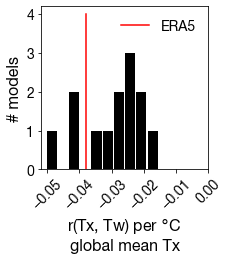

In [60]:
obs_gmt_slope_ratio = -0.038118621780981944
plt.figure(figsize=(3,3))
plt.hist(cmip6_gmt_slope_ratio, fc='black', rwidth=.9)
plt.plot([obs_gmt_slope_ratio,obs_gmt_slope_ratio], [0,4], c='red', label='ERA5')
plt.xticks([-.05, -.04, -.03, -.02, -.01, 0], rotation=45)
plt.ylabel('# models')
plt.xlabel('r(Tx, Tw) per $\degree$C\nglobal mean Tx')
l = plt.legend(fontsize=14, framealpha=.75, )
l.get_frame().set_linewidth(0)

Text(0, 0.5, 'Global mean r(Tx, Tw)\nchange per $\\degree$C\n(1981-2021)')

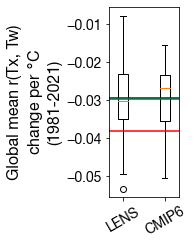

In [61]:
plt.figure(figsize=(1.25,3.5))
# plt.ylim([-.012, 0]?)
plt.xlim([.5, 1.5])
plt.boxplot([lens_r_tx_tw_per_gmt, cmip6_gmt_slope_ratio], positions=[.7, 1.3])
plt.plot([.5, 1.5], [obs_gmt_slope_ratio, obs_gmt_slope_ratio], '-r', label='ERA5')
plt.plot([.5, 1.5], [np.nanmean(cmip6_gmt_slope_ratio), np.nanmean(cmip6_gmt_slope_ratio)], '-b', label='CMIP6\nmean')
plt.plot([.5, 1.5], [np.nanmean(lens_r_tx_tw_per_gmt), np.nanmean(lens_r_tx_tw_per_gmt)], '-g', label='LENS\nmean')
plt.xticks([.7,1.3], rotation=30)
plt.gca().set_xticklabels(['LENS', 'CMIP6'])
plt.ylabel('Global mean r(Tx, Tw)\nchange per $\degree$C\n(1981-2021)')
# l = plt.legend(fontsize=14, framealpha=.75, bbox_to_anchor=(1.05, 1.0), loc='upper left')
# l.get_frame().set_linewidth(0)
# plt.savefig('r(tx,tw)-vs-gmt-cmip6-lens-era5-hist.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

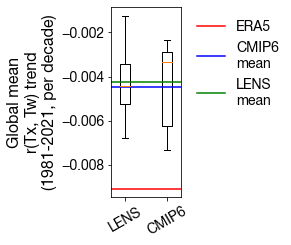

In [31]:
plt.figure(figsize=(1.25,3.5))
# plt.ylim([-.012, 0]?)
# plt.boxplot(1, lens_tx_tw_corr_slopes)
# plt.boxplot(2, corr_ts_slopes)
plt.boxplot([lens_tx_tw_corr_slopes, corr_ts_slopes], positions=[.7, 1.3])
plt.xlim([.5, 1.5])
plt.plot([0, 2], [obs_slope, obs_slope], '-r', label='ERA5')
plt.plot([0, 2], [np.nanmean(corr_ts_slopes), np.nanmean(corr_ts_slopes)], '-b', label='CMIP6\nmean')
plt.plot([0, 2], [np.nanmean(lens_tx_tw_corr_slopes), np.nanmean(lens_tx_tw_corr_slopes)], '-g', label='LENS\nmean')

plt.ylabel('Global mean\nr(Tx, Tw) trend\n(1981-2021, per decade)')
plt.xticks([.7, 1.3], rotation=30)
plt.gca().set_xticklabels(['LENS', 'CMIP6'])

l = plt.legend(fontsize=14, framealpha=.75, bbox_to_anchor=(1.05, 1.0), loc='upper left')
l.get_frame().set_linewidth(0)

# plt.savefig('r(tx,tw)-trend-cmip6-lens-era5.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

Text(0, 0.5, 'Global mean\nTx|Tw - $Tx_{100}$ trend\n($\\degree$C per decade)')

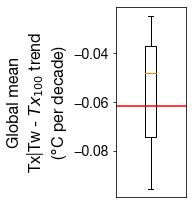

In [90]:
plt.figure(figsize=(1.25,3.5))
# plt.ylim([-.012, 0]?)
plt.boxplot(cmip6_tx_tw_minus_tx_tx_slopes)
plt.plot([.5, 1.5], [era5_tx_tw_vs_tx_tx_trend, era5_tx_tw_vs_tx_tx_trend], '-r')
plt.xticks([])
plt.ylabel('Global mean\nTx|Tw - $Tx_{100}$ trend\n($\degree$C per decade)')

Text(0, 0.5, 'Global mean\nTw|Tx - $Tw_{100}$ trend\n($\\degree$C per decade)')

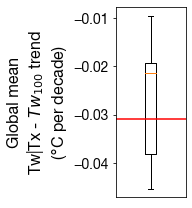

In [91]:
plt.figure(figsize=(1.25,3.5))
# plt.ylim([-.012, 0]?)
plt.boxplot(cmip6_tw_tx_minus_tw_tw_slopes)
plt.plot([.5, 1.5], [era5_tw_tx_vs_tw_tw_trend, era5_tw_tx_vs_tw_tw_trend], '-r')
plt.xticks([])
plt.ylabel('Global mean\nTw|Tx - $Tw_{100}$ trend\n($\degree$C per decade)')

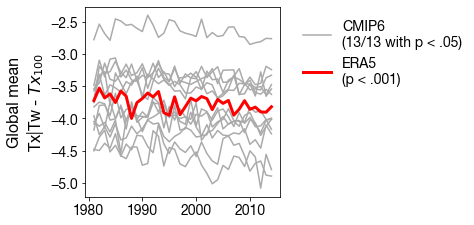

In [120]:
plt.figure(figsize=(3.5,3.5))

plt.plot(np.arange(1981,2015), cmip6_tx_tw_minus_tx_tx_spatial_mean.T[0:34,0], c='#aaaaaa', label='CMIP6\n(%d/%d with p < .05)'%(np.where(cmip6_tx_tw_minus_tx_tx_pvals.values<.05)[0].size, cmip6_tx_tw_minus_tx_tx_pvals.size))
plt.plot(np.arange(1981,2015), cmip6_tx_tw_minus_tx_tx_spatial_mean.T[0:34,1:], c='#aaaaaa')
plt.plot(np.arange(1981,2015), era5_tx_tw_minus_tx_tx[0:34], c='r', lw=3, label='ERA5\n(p < .001)')


plt.xticks([1980, 1990, 2000, 2010])
plt.ylabel('Global mean\nTx|Tw - $Tx_{100}$')
l = plt.legend(fontsize=14, framealpha=.75, bbox_to_anchor=(1.05, 1.0), loc='upper left')
l.get_frame().set_linewidth(0)

ValueError: x and y must have same first dimension, but have shapes (34,) and (120,)

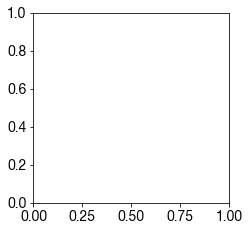

In [93]:
plt.figure(figsize=(3.5,3.5))

plt.plot(np.arange(1981,2015), cmip6_tw_tx_minus_tw_tw_spatial_mean.T[:,0], c='#aaaaaa', label='CMIP6\n(%d/%d with p < .05)'%(np.where(cmip6_tw_tx_minus_tw_tw_pvals.values<.05)[0].size, cmip6_tw_tx_minus_tw_tw_pvals.size))
plt.plot(np.arange(1981,2015), cmip6_tw_tx_minus_tw_tw_spatial_mean.T[:,1:], c='#aaaaaa')
plt.plot(np.arange(1981,2015), era5_tw_tx_minus_tw_tw[0:34], c='r', lw=3, label='ERA5\n(p < .001)')


plt.xticks([1980, 1990, 2000, 2010])
plt.ylabel('Global mean\nTw|Tx - $Tw_{100}$')
l = plt.legend(fontsize=14, framealpha=.75, bbox_to_anchor=(1.05, 1.0), loc='upper left')
l.get_frame().set_linewidth(0)

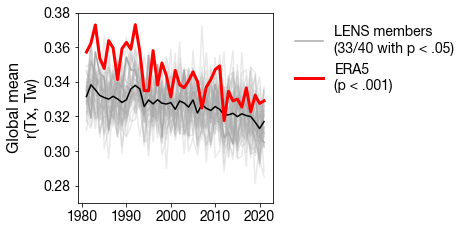

In [94]:
plt.figure(figsize=(3.5,3.5))
plt.ylim([.27, .38])

plt.plot(np.arange(1981,2021+1), lens_tx_tw_ensemble_members_spatial_mean.tw.values.T[:,0], c='#aaaaaa', alpha=1, label='LENS members\n(%d/%d with p < .05)'%(np.where(lens_tx_tw_corr_pvals<.05)[0].size, lens_tx_tw_corr_pvals.size))
plt.plot(np.arange(1981,2021+1), lens_tx_tw_ensemble_members_spatial_mean.tw.values.T[:,:], c='#aaaaaa', alpha=.25)
plt.plot(np.arange(1981,2021+1), np.nanmean(lens_tx_tw_ensemble_members_spatial_mean.tw.values.T, axis=1), c='k')
plt.plot(np.arange(1981,2021+1), tx_tw_corr_ts.tx_tw_corr, c='r', lw=3, label='ERA5\n(p < .001)')

plt.xticks([1980, 1990, 2000, 2010, 2020])
plt.ylabel('Global mean\nr(Tx, Tw)')
l = plt.legend(fontsize=14, framealpha=.75, bbox_to_anchor=(1.05, 1.0), loc='upper left')
l.get_frame().set_linewidth(0)

In [96]:
cmip6_tx_tw_corr_detrend = np.full(corr_ts.shape, np.nan)
cmip6_tx_tw_minus_tx_tx_detrend = np.full(cmip6_tx_tw_minus_tx_tx_spatial_mean.shape, np.nan)
cmip6_tw_tx_minus_tw_tw_detrend = np.full(cmip6_tw_tx_minus_tw_tw_spatial_mean.shape, np.nan)

cmip6_tx_tw_minus_tx_tx_r2 = np.full([len(cmip6_models)], np.nan)
cmip6_tw_tx_minus_tw_tw_r2 = np.full([len(cmip6_models)], np.nan)

for m in range(len(cmip6_models)):
    cmip6_tx_tw_corr_detrend[m,:] = signal.detrend(corr_ts[m,:])
    cmip6_tx_tw_minus_tx_tx_detrend[m,:] = signal.detrend(cmip6_tx_tw_minus_tx_tx_spatial_mean[m,:])
    cmip6_tw_tx_minus_tw_tw_detrend[m,:] = signal.detrend(cmip6_tw_tx_minus_tw_tw_spatial_mean[m,:])
    
    X = sm.add_constant(cmip6_tx_tw_corr_detrend[m, :])
    mdl_tx_tw_minus_tx_tx = sm.OLS(cmip6_tx_tw_minus_tx_tx_detrend[m, :], X).fit()
    mdl_tw_tx_minus_tw_tw = sm.OLS(cmip6_tw_tx_minus_tw_tw_detrend[m, :], X).fit()
    
    cmip6_tx_tw_minus_tx_tx_r2[m] = mdl_tx_tw_minus_tx_tx.rsquared
    cmip6_tw_tx_minus_tw_tw_r2[m] = mdl_tw_tx_minus_tw_tw.rsquared


ValueError: illegal value in 4-th argument of internal None

In [ ]:
plt.figure(figsize=(4,4))
plt.hist(cmip6_tx_tw_minus_tx_tx_r2, color='k')

plt.ylabel('# CMIP6 models')
plt.xlabel('$R^2$ between global mean\nr(T, ET) and Tx | $Tw_{100}$ - $Tx_{100}$')

In [ ]:
plt.figure(figsize=(4,4))
plt.hist(cmip6_tw_tx_minus_tw_tw_r2, color='k')

plt.ylabel('# CMIP6 models')
plt.xlabel('$R^2$ between global mean\nr(T, ET) and Tw | $Tx_{100}$ - $Tw_{100}$')

In [ ]:
cmip6_tx_tw_corr_detrend_norm = cmip6_tx_tw_corr_detrend-np.nanmean(cmip6_tx_tw_corr_detrend, axis=0)
cmip6_tw_tx_minus_tw_tw_detrend_norm = cmip6_tw_tx_minus_tw_tw_detrend-np.nanmean(cmip6_tw_tx_minus_tw_tw_detrend, axis=0)
cmip6_tx_tw_minus_tx_tx_detrend_norm = cmip6_tx_tw_minus_tx_tx_detrend-np.nanmean(cmip6_tx_tw_minus_tx_tx_detrend, axis=0)

In [ ]:
x_all = cmip6_tx_tw_corr_detrend_norm.reshape([cmip6_tx_tw_corr_detrend_norm.size])
y_all = cmip6_tw_tx_minus_tw_tw_detrend_norm.reshape([cmip6_tw_tx_minus_tw_tw_detrend_norm.size])
X = sm.add_constant(x_all)
mdl = sm.OLS(y_all, X).fit()

x1 = -.025
x2 = 0.025

plt.figure(figsize=(4,4))
plt.scatter(x_all, y_all, c='k')
plt.plot([x1,x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--r', lw=2, label='$R^2$ = %.2f'%mdl.rsquared)

plt.xlabel('Global mean r(Tx, Tw)\ndetrended anomaly')
# plt.xticks([.48, .5, .52, .54])
plt.ylabel('Global mean\nTw | $Tx_{100}$ - $Tw_{100}$\ndetrended, normalized anomaly')
font = FontProperties(family='Arial', size=14)
plt.legend(frameon=False, fontsize=14, prop=font)

In [ ]:
x_all = cmip6_tx_tw_corr_detrend_norm.reshape([cmip6_tx_tw_corr_detrend_norm.size])
y_all = cmip6_tx_tw_minus_tx_tx_detrend_norm.reshape([cmip6_tx_tw_minus_tx_tx_detrend_norm.size])
X = sm.add_constant(x_all)
mdl = sm.OLS(y_all, X).fit()

x1 = -.025
x2 = 0.025

plt.figure(figsize=(4,4))
plt.scatter(x_all, y_all, c='k')
plt.plot([x1,x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--r', lw=2, label='$R^2$ = %.2f'%mdl.rsquared)

plt.xlabel('Global mean r(Tx, Tw)\ndetrended anomaly')
# plt.xticks([.48, .5, .52, .54])
plt.ylabel('Global mean\nTx | $Tw_{100}$ - $Tx_{100}$\ndetrended, normalized anomaly')
font = FontProperties(family='Arial', size=14)
plt.legend(frameon=False, fontsize=14, prop=font)

In [ ]:

plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -1
v2 = 1.1
vstep = .1
vlabelstep = .25

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = tx_tw_corr_mean_regrid

c = plt.pcolormesh(tx_tw_corr_mean_regrid.lon, tx_tw_corr_mean_regrid.lat, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('r(Tx, Tw): ERA5', fontsize=20)

# plt.savefig('t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


In [ ]:

plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -1
v2 = 1.1
vstep = .1
vlabelstep = .25

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = corr_spatial.tx_tw_corr.mean(dim=['model', 'year']).values

c = plt.pcolormesh(cur_tx_tw_corr.lon, cur_tx_tw_corr.lat, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('r(Tx, Tw): CMIP6 mean', fontsize=20)

# plt.savefig('t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


In [ ]:

plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -.5
v2 = .51
vstep = .05
vlabelstep = .1

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = corr_spatial.tx_tw_corr.mean(dim=['model', 'year']).values - tx_tw_corr_mean_regrid

c = plt.pcolormesh(cur_tx_tw_corr.lon, cur_tx_tw_corr.lat, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('r(Tx, Tw): CMIP6 mean - ERA5', fontsize=20)

# plt.savefig('t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


In [ ]:
plt.figure(figsize=(1.25,3.5))
plt.ylim([-.012, 0])
plt.boxplot(corr_ts_slopes)
plt.plot([.5, 1.5], [obs_slope, obs_slope], '-r')
plt.xticks([])
plt.ylabel('Global mean\nr(Tx, Tw) trend\n(per decade)')

In [ ]:
np.where(np.array(corr_ts_pvals)<.05)[0].size,np.array(corr_ts_pvals).size

In [ ]:
plt.figure(figsize=(3.5,3.5))
plt.plot(tx_tw_corr_ts.time.dt.year.values, corr_ts[0,0:34].T, c='#aaaaaa', label='CMIP6\n(8/18 with p < .05)')
plt.plot(tx_tw_corr_ts.time.dt.year.values, corr_ts[1:,0:34].T, c='#aaaaaa')
plt.plot(tx_tw_corr_ts.time.dt.year.values, tx_tw_corr_ts.tx_tw_corr, c='r', lw=3, label='ERA5\n(p < .001)')
plt.xticks([1980, 1990, 2000, 2010])
plt.ylabel('Global mean\nr(Tx, Tw)')
l = plt.legend(fontsize=14, framealpha=.75, bbox_to_anchor=(1.05, 1.0), loc='upper left')
l.get_frame().set_linewidth(0)

In [ ]:
# CALC SPATIAL TREND IN CORR

from datetime import datetime
def add_time_dim(xda):
    xda = xda.expand_dims(time = [datetime.now()])
    return xda

time_dim = pd.date_range("1981-01-01", "2021-12-31", freq="AS")
cmip6_var = xr.open_dataset('tx_tw_corr_%s.nc'%cmip6_models[0])
cmip6_var = cmip6_var.rename({'__xarray_dataarray_variable__':'tx_tw_corr'})
cmip6_var['year'] = time_dim
cmip6_var = cmip6_var.chunk(chunks={"year": -1, "lat": 50, "lon": 50})
cmip6_var = cmip6_var.chunk({"year": -1})
# era5_var_deciles = era5_var_deciles.chunk({"quantile": -1})

In [ ]:

def linregress_ufunc(x, y):
    # Remove rows where either x or y is nan
    mask = ~np.isnan(x) & ~np.isnan(y)
    x = x[mask]
    y = y[mask]

    # If all values are nan or the length of x, y are less than 2, return nan
    if len(x) < 2 or len(y) < 2:
        return (np.nan, np.nan)

    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return slope, p_value

# rest of the code remains the same


def apply_trend_and_pvalue(ds, time_dim='year', x_dim='lon', y_dim='lat'):
    # Extract the year information from the time coordinates
    time_years = ds[time_dim].dt.year.values
    unique_years = np.unique(time_years)
    
    # Broadcast unique_years along the time dimension
    unique_years_broadcasted = xr.DataArray(unique_years, dims=[time_dim], coords={time_dim: ds[time_dim]})
    
    trend, p_value = xr.apply_ufunc(
        linregress_ufunc,
        unique_years_broadcasted,
        ds,
        input_core_dims=[[time_dim], [time_dim]],
        output_core_dims=[[], []],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float, float]
    )

    trend = trend.rename("tx_tw_corr_trend")
    p_value = p_value.rename("tx_tw_corr_trend_p_value")
    
    return xr.merge([trend, p_value])



